In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 29.1 GB  | Proc size: 50.7 MB
GPU RAM Free: 10830MB | Used: 434MB | Util   4% | Total 11264MB


In [3]:
# Clone repo
#!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [4]:
# Change directory
%cd keras_triplet_descriptor    


C:\Users\User\Downloads\keras_triplet_descriptor


In [5]:
# Download data
#!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [6]:
# Extract data
#!unzip -q ./hpatches_data.zip
#!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [7]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [8]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [9]:
hpatches_dir = './hpatches'
splits_path = 'splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   

In [10]:
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 

In [11]:
len(seqs)

116

In [12]:
len(seqs_train)

76

In [13]:
len(seqs_test)

40

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [14]:
def get_denoise_model(shape, do = 0, activate = 'selu'):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate , padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation =  activate, padding='same')(pool4)))
    conv5 = (Conv2D(512, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv5))

    up6 = concatenate([conv5, conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(up6)))
    conv6 = (Conv2D(256, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv6))

    up7 = concatenate([conv6, conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(up7)))
    conv7 = (Conv2D(128, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv7))

    up8 = concatenate([conv7, conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(up8)))
    conv8 = (Conv2D(64, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv8))

    up9 = concatenate([conv8, conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model



def get_descriptor_model(init_weights, shape, activate= 'elu'):
  
    '''Architecture copies HardNet architecture'''

    #init_weights = keras.initializers.he_normal()

    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation(activate))
    descriptor_model.add(Dropout(0.5))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

    # Final descriptor reshape
    descriptor_model.add(Reshape((128,)))

    return descriptor_model
  

def triplet_loss(x):
  
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)

    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [15]:
from keras.layers import LeakyReLU
shape = (32, 32, 1)
denoise_model = keras.models.load_model('./denoise_modified.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [17]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

descriptor_model_relu = get_descriptor_model(0, shape)
ea = descriptor_model_relu(xa)
ep = descriptor_model_relu(xp)
en = descriptor_model_relu(xn)
loss_relu = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_elu = get_descriptor_model(0.1, shape)
ea = descriptor_model_elu(xa)
ep = descriptor_model_elu(xp)
en = descriptor_model_elu(xn)
loss_elu = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_selu = get_descriptor_model(0.2, shape)
ea = descriptor_model_selu(xa)
ep = descriptor_model_selu(xp)
en = descriptor_model_selu(xn)
loss_selu = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_lin = get_descriptor_model(0.3, shape)
ea = descriptor_model_lin(xa)
ep = descriptor_model_lin(xp)
en = descriptor_model_lin(xn)
loss_lin = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_lrelu = get_descriptor_model(0.4, shape)
ea = descriptor_model_lrelu(xa)
ep = descriptor_model_lrelu(xp)
en = descriptor_model_lrelu(xn)
loss_lrelu = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_do5 = get_descriptor_model(0.5, shape)
ea = descriptor_model_lrelu(xa)
ep = descriptor_model_lrelu(xp)
en = descriptor_model_lrelu(xn)
loss_do5 = Lambda(triplet_loss)([ea, ep, en])



adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

descriptor_model_trip_relu = Model(inputs=[xa, xp, xn], outputs=loss_relu)
descriptor_model_trip_elu = Model(inputs=[xa, xp, xn], outputs=loss_elu)
descriptor_model_trip_selu = Model(inputs=[xa, xp, xn], outputs=loss_selu)
descriptor_model_trip_lin = Model(inputs=[xa, xp, xn], outputs=loss_lin)
descriptor_model_trip_lrelu = Model(inputs=[xa, xp, xn], outputs=loss_lrelu)
descriptor_model_trip_do5 = Model(inputs=[xa, xp, xn], outputs=loss_do5)


descriptor_model_trip_relu.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_elu.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_selu.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_lin.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_lrelu.compile(loss='mean_absolute_error', optimizer=adam)
descriptor_model_trip_do5.compile(loss='mean_absolute_error', optimizer=adam)

Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [18]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)

# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:04<00:00,  1.81it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [10:13<00:00, 26.36it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 46095.94it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:42<00:00,  1.92it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [06:07<00:00, 25.94it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 40424.96it/s]


We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

In [19]:
plot_triplet(training_generator)

<Figure size 640x480 with 3 Axes>

We now train the descriptor model and save the weights afterward.

In [20]:
#epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

#for e in range(epochs):
  
descriptor_history_relu = descriptor_model_trip_relu.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5') 

descriptor_history_elu = descriptor_model_trip_elu.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5') 

descriptor_history_selu = descriptor_model_trip_selu.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5')

descriptor_history_lin = descriptor_model_trip_lin.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5') 

descriptor_history_lrelu = descriptor_model_trip_lrelu.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)
#descriptor_model_trip.save('descriptor_relu.h5') 

descriptor_history_do5 = descriptor_model_trip_do5.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)

### Saves optimizer and weights
#descriptor_model_trip.save('descriptor.h5') 
### Uploads files to external hosting
#!curl -F "file=@descriptor.h5" https://file.io


Epoch 1/5


 313/2000 [===>..........................] - ETA: 4:36:56 - loss: 0.50 - ETA: 2:19:38 - loss: 0.47 - ETA: 1:33:44 - loss: 0.49 - ETA: 1:10:45 - loss: 0.47 - ETA: 57:03 - loss: 0.4458 - ETA: 47:55 - loss: 0.59 - ETA: 41:22 - loss: 0.54 - ETA: 36:27 - loss: 0.53 - ETA: 32:36 - loss: 0.56 - ETA: 29:32 - loss: 0.54 - ETA: 27:02 - loss: 0.56 - ETA: 24:57 - loss: 0.56 - ETA: 23:09 - loss: 0.54 - ETA: 21:38 - loss: 0.51 - ETA: 20:19 - loss: 0.49 - ETA: 19:09 - loss: 0.52 - ETA: 18:09 - loss: 0.53 - ETA: 17:14 - loss: 0.51 - ETA: 16:25 - loss: 0.49 - ETA: 15:41 - loss: 0.49 - ETA: 15:01 - loss: 0.51 - ETA: 14:24 - loss: 0.49 - ETA: 13:51 - loss: 0.48 - ETA: 13:21 - loss: 0.50 - ETA: 12:53 - loss: 0.52 - ETA: 12:27 - loss: 0.51 - ETA: 12:03 - loss: 0.50 - ETA: 11:42 - loss: 0.50 - ETA: 11:21 - loss: 0.51 - ETA: 11:02 - loss: 0.51 - ETA: 10:44 - loss: 0.51 - ETA: 10:27 - loss: 0.51 - ETA: 10:11 - loss: 0.50 - ETA: 9:56 - loss: 0.4920 - ETA: 9:42 - loss: 0.494 - ETA: 9:28 - loss: 0.502 - ETA: 9:1

 941/2000 [=============>................] - ETA: 1:37 - loss: 0.302 - ETA: 1:37 - loss: 0.302 - ETA: 1:37 - loss: 0.302 - ETA: 1:37 - loss: 0.302 - ETA: 1:37 - loss: 0.302 - ETA: 1:37 - loss: 0.302 - ETA: 1:37 - loss: 0.302 - ETA: 1:36 - loss: 0.302 - ETA: 1:36 - loss: 0.302 - ETA: 1:36 - loss: 0.302 - ETA: 1:36 - loss: 0.302 - ETA: 1:36 - loss: 0.301 - ETA: 1:36 - loss: 0.301 - ETA: 1:36 - loss: 0.301 - ETA: 1:36 - loss: 0.301 - ETA: 1:36 - loss: 0.301 - ETA: 1:36 - loss: 0.301 - ETA: 1:35 - loss: 0.301 - ETA: 1:35 - loss: 0.301 - ETA: 1:35 - loss: 0.301 - ETA: 1:35 - loss: 0.301 - ETA: 1:35 - loss: 0.301 - ETA: 1:35 - loss: 0.301 - ETA: 1:35 - loss: 0.301 - ETA: 1:35 - loss: 0.300 - ETA: 1:35 - loss: 0.300 - ETA: 1:35 - loss: 0.300 - ETA: 1:34 - loss: 0.300 - ETA: 1:34 - loss: 0.300 - ETA: 1:34 - loss: 0.300 - ETA: 1:34 - loss: 0.300 - ETA: 1:34 - loss: 0.299 - ETA: 1:34 - loss: 0.299 - ETA: 1:34 - loss: 0.299 - ETA: 1:34 - loss: 0.299 - ETA: 1:34 - loss: 0.299 - ETA: 1:34 - loss: 0

1269/2000 [==================>...........] - ETA: 1:10 - loss: 0.277 - ETA: 1:10 - loss: 0.277 - ETA: 1:10 - loss: 0.277 - ETA: 1:10 - loss: 0.277 - ETA: 1:10 - loss: 0.277 - ETA: 1:10 - loss: 0.277 - ETA: 1:10 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:09 - loss: 0.277 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.275 - ETA: 1:08 - loss: 0.275 - ETA: 1:08 - loss: 0.275 - ETA: 1:08 - loss: 0.275 - ETA: 1:08 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:07 - loss: 0

1610/2000 [=======================>......] - ETA: 47s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 46s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 45s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.

1950/2000 [============================>.] - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.25 - ETA: 24s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.24 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.243 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.243 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.242 - ETA: 2s - loss: 0.243 - ETA: 1s - loss: 0.243 - ETA: 1s - loss: 0.243 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 1s - loss: 0.242 - ETA: 0s - loss: 0.242 - ETA: 0s - loss: 0.242 - ETA: 0s - loss: 0.242 - ETA: 0s - loss: 0.242 - ETA: 0s - loss: 0.242 - ETA: 0s - loss: 0.242 - ETA: 0s - loss: 0.2

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 31431.80it/s]


2000/2000 [==============================] - 134s 67ms/step - loss: 0.2423 - val_loss: 0.2794
Epoch 2/5
   1/2000 [..............................] - ETA: 2:05 - loss: 0.1854

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107711). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 5:28 - loss: 0.1368

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100738). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 5:44 - loss: 0.168 - ETA: 5:22 - loss: 0.187 - ETA: 6:36 - loss: 0.1791

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 5:57 - loss: 0.1603

 31%|██████████████████████▊                                                   | 3090/10000 [00:00<00:00, 30658.01it/s]

   7/2000 [..............................]

 59%|███████████████████████████████████████████▊                              | 5928/10000 [00:00<00:00, 29870.32it/s]

 - ETA: 5:55 - loss: 0.1442

 89%|██████████████████████████████████████████████████████████████████▏       | 8937/10000 [00:00<00:00, 29871.07it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29318.13it/s]

   8/2000 [..............................] - ETA: 5:46 - loss: 0.1796

 322/2000 [===>..........................] - ETA: 5:41 - loss: 0.170 - ETA: 5:23 - loss: 0.183 - ETA: 5:05 - loss: 0.173 - ETA: 4:50 - loss: 0.176 - ETA: 4:37 - loss: 0.172 - ETA: 4:26 - loss: 0.169 - ETA: 4:15 - loss: 0.181 - ETA: 4:07 - loss: 0.182 - ETA: 4:00 - loss: 0.174 - ETA: 3:54 - loss: 0.170 - ETA: 3:48 - loss: 0.168 - ETA: 3:43 - loss: 0.176 - ETA: 3:38 - loss: 0.177 - ETA: 3:35 - loss: 0.174 - ETA: 3:31 - loss: 0.172 - ETA: 3:28 - loss: 0.171 - ETA: 3:25 - loss: 0.170 - ETA: 3:22 - loss: 0.167 - ETA: 3:19 - loss: 0.166 - ETA: 3:16 - loss: 0.170 - ETA: 3:13 - loss: 0.167 - ETA: 3:11 - loss: 0.169 - ETA: 3:10 - loss: 0.173 - ETA: 3:07 - loss: 0.173 - ETA: 3:06 - loss: 0.172 - ETA: 3:04 - loss: 0.175 - ETA: 3:02 - loss: 0.175 - ETA: 3:01 - loss: 0.174 - ETA: 3:00 - loss: 0.177 - ETA: 2:58 - loss: 0.177 - ETA: 2:57 - loss: 0.176 - ETA: 2:55 - loss: 0.177 - ETA: 2:54 - loss: 0.174 - ETA: 2:53 - loss: 0.176 - ETA: 2:52 - loss: 0.175 - ETA: 2:51 - loss: 0.175 - ETA: 2:49 - loss: 0

 637/2000 [========>.....................] - ETA: 1:46 - loss: 0.193 - ETA: 1:46 - loss: 0.194 - ETA: 1:45 - loss: 0.193 - ETA: 1:45 - loss: 0.193 - ETA: 1:45 - loss: 0.193 - ETA: 1:45 - loss: 0.193 - ETA: 1:45 - loss: 0.194 - ETA: 1:45 - loss: 0.194 - ETA: 1:45 - loss: 0.194 - ETA: 1:45 - loss: 0.194 - ETA: 1:45 - loss: 0.194 - ETA: 1:45 - loss: 0.193 - ETA: 1:45 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:44 - loss: 0.193 - ETA: 1:43 - loss: 0.193 - ETA: 1:43 - loss: 0.193 - ETA: 1:43 - loss: 0.193 - ETA: 1:43 - loss: 0.193 - ETA: 1:43 - loss: 0.193 - ETA: 1:43 - loss: 0.194 - ETA: 1:43 - loss: 0.194 - ETA: 1:43 - loss: 0.194 - ETA: 1:43 - loss: 0.194 - ETA: 1:43 - loss: 0.195 - ETA: 1:43 - loss: 0.195 - ETA: 1:42 - loss: 0.195 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0

 952/2000 [=============>................] - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.190 - ETA: 1:22 - loss: 0.191 - ETA: 1:22 - loss: 0.191 - ETA: 1:22 - loss: 0.191 - ETA: 1:22 - loss: 0.191 - ETA: 1:22 - loss: 0.191 - ETA: 1:22 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:21 - loss: 0.191 - ETA: 1:20 - loss: 0.191 - ETA: 1:20 - loss: 0.191 - ETA: 1:20 - loss: 0.191 - ETA: 1:20 - loss: 0.191 - ETA: 1:20 - loss: 0

1291/2000 [==================>...........] - ETA: 1:02 - loss: 0.189 - ETA: 1:02 - loss: 0.189 - ETA: 1:02 - loss: 0.189 - ETA: 1:02 - loss: 0.189 - ETA: 1:02 - loss: 0.189 - ETA: 1:02 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.189 - ETA: 1:01 - loss: 0.190 - ETA: 1:00 - loss: 0.190 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 1:00 - loss: 0.189 - ETA: 59s - loss: 0.190 - ETA: 59s - loss: 0.1

1632/2000 [=======================>......] - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 41s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.

1972/2000 [============================>.] - ETA: 21s - loss: 0.18 - ETA: 21s - loss: 0.18 - ETA: 21s - loss: 0.18 - ETA: 21s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 20s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 19s - loss: 0.18 - ETA: 18s - loss: 0.18 - ETA: 18s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 1s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.184 - ETA: 0s - loss: 0.1843

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 37524.78it/s]


2000/2000 [==============================] - 122s 61ms/step - loss: 0.1843 - val_loss: 0.2081
Epoch 3/5
   7/2000 [..............................] - ETA: 6:10 - loss: 0.125 - ETA: 5:25 - loss: 0.205 - ETA: 5:28 - loss: 0.192 - ETA: 5:24 - loss: 0.188 - ETA: 5:23 - loss: 0.164 - ETA: 5:29 - loss: 0.182 - ETA: 5:50 - loss: 0.1704

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 30%|██████████████████████                                                    | 2973/10000 [00:00<00:00, 29511.70it/s]

   8/2000 [..............................] - ETA: 5:31 - loss: 0.1765

 60%|████████████████████████████████████████████▍                             | 6002/10000 [00:00<00:00, 29677.69it/s]

   9/2000 [..............................] - ETA: 5:34 - loss: 0.1777

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29147.68it/s]


 323/2000 [===>..........................] - ETA: 5:27 - loss: 0.170 - ETA: 5:17 - loss: 0.171 - ETA: 5:02 - loss: 0.165 - ETA: 4:48 - loss: 0.172 - ETA: 4:37 - loss: 0.168 - ETA: 4:28 - loss: 0.168 - ETA: 4:18 - loss: 0.165 - ETA: 4:10 - loss: 0.163 - ETA: 4:03 - loss: 0.160 - ETA: 3:57 - loss: 0.157 - ETA: 3:51 - loss: 0.159 - ETA: 3:46 - loss: 0.161 - ETA: 3:41 - loss: 0.162 - ETA: 3:37 - loss: 0.165 - ETA: 3:33 - loss: 0.161 - ETA: 3:30 - loss: 0.160 - ETA: 3:26 - loss: 0.165 - ETA: 3:23 - loss: 0.162 - ETA: 3:21 - loss: 0.171 - ETA: 3:19 - loss: 0.167 - ETA: 3:16 - loss: 0.165 - ETA: 3:14 - loss: 0.164 - ETA: 3:11 - loss: 0.169 - ETA: 3:09 - loss: 0.173 - ETA: 3:07 - loss: 0.171 - ETA: 3:05 - loss: 0.168 - ETA: 3:04 - loss: 0.166 - ETA: 3:02 - loss: 0.169 - ETA: 3:00 - loss: 0.170 - ETA: 2:58 - loss: 0.168 - ETA: 2:57 - loss: 0.174 - ETA: 2:55 - loss: 0.171 - ETA: 2:54 - loss: 0.170 - ETA: 2:53 - loss: 0.168 - ETA: 2:51 - loss: 0.168 - ETA: 2:50 - loss: 0.169 - ETA: 2:49 - loss: 0

 638/2000 [========>.....................] - ETA: 1:49 - loss: 0.175 - ETA: 1:49 - loss: 0.175 - ETA: 1:49 - loss: 0.175 - ETA: 1:49 - loss: 0.175 - ETA: 1:49 - loss: 0.175 - ETA: 1:49 - loss: 0.175 - ETA: 1:49 - loss: 0.175 - ETA: 1:49 - loss: 0.174 - ETA: 1:49 - loss: 0.174 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.173 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.173 - ETA: 1:48 - loss: 0.173 - ETA: 1:48 - loss: 0.173 - ETA: 1:48 - loss: 0.174 - ETA: 1:48 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:47 - loss: 0.173 - ETA: 1:46 - loss: 0.173 - ETA: 1:46 - loss: 0.173 - ETA: 1:46 - loss: 0

 953/2000 [=============>................] - ETA: 1:24 - loss: 0.172 - ETA: 1:24 - loss: 0.172 - ETA: 1:24 - loss: 0.172 - ETA: 1:24 - loss: 0.172 - ETA: 1:24 - loss: 0.172 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.173 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.173 - ETA: 1:23 - loss: 0.172 - ETA: 1:23 - loss: 0.173 - ETA: 1:22 - loss: 0.172 - ETA: 1:22 - loss: 0.172 - ETA: 1:22 - loss: 0.172 - ETA: 1:22 - loss: 0.172 - ETA: 1:22 - loss: 0.173 - ETA: 1:22 - loss: 0.173 - ETA: 1:22 - loss: 0.173 - ETA: 1:22 - loss: 0.173 - ETA: 1:22 - loss: 0.173 - ETA: 1:22 - loss: 0.173 - ETA: 1:22 - loss: 0.173 - ETA: 1:22 - loss: 0.174 - ETA: 1:22 - loss: 0.173 - ETA: 1:22 - loss: 0.174 - ETA: 1:21 - loss: 0.174 - ETA: 1:21 - loss: 0.174 - ETA: 1:21 - loss: 0.173 - ETA: 1:21 - loss: 0.174 - ETA: 1:21 - loss: 0

1289/2000 [==================>...........] - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:02 - loss: 0.172 - ETA: 1:01 - loss: 0.172 - ETA: 1:01 - loss: 0.172 - ETA: 1:01 - loss: 0.172 - ETA: 1:01 - loss: 0.172 - ETA: 1:01 - loss: 0.172 - ETA: 1:01 - loss: 0.172 - ETA: 1:01 - loss: 0.172 - ETA: 1:01 - loss: 0.172 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.172 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0

1629/2000 [=======================>......] - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 42s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.16 - ETA: 40s - loss: 0.

1971/2000 [============================>.] - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.16 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 1s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.164 - ETA: 0s - loss: 0.1647

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41829.01it/s]


2000/2000 [==============================] - 125s 63ms/step - loss: 0.1647 - val_loss: 0.1965
Epoch 4/5
   2/2000 [..............................] - ETA: 6:40 - loss: 0.052 - ETA: 5:12 - loss: 0.1193

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116675). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:38 - loss: 0.103 - ETA: 6:13 - loss: 0.139 - ETA: 6:00 - loss: 0.131 - ETA: 6:29 - loss: 0.1210

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................]

 28%|█████████████████████                                                     | 2840/10000 [00:00<00:00, 28194.13it/s]

 - ETA: 5:56 - loss: 0.121

 62%|██████████████████████████████████████████████                            | 6231/10000 [00:00<00:00, 29662.65it/s]

   8/2000 [..............................] - ETA: 5:49 - loss: 0.1155

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33790.10it/s]


 323/2000 [===>..........................] - ETA: 5:45 - loss: 0.131 - ETA: 5:25 - loss: 0.134 - ETA: 5:06 - loss: 0.141 - ETA: 4:51 - loss: 0.142 - ETA: 4:39 - loss: 0.139 - ETA: 4:27 - loss: 0.149 - ETA: 4:17 - loss: 0.148 - ETA: 4:08 - loss: 0.140 - ETA: 4:00 - loss: 0.138 - ETA: 3:52 - loss: 0.139 - ETA: 3:46 - loss: 0.142 - ETA: 3:40 - loss: 0.147 - ETA: 3:34 - loss: 0.143 - ETA: 3:29 - loss: 0.143 - ETA: 3:25 - loss: 0.145 - ETA: 3:20 - loss: 0.147 - ETA: 3:16 - loss: 0.149 - ETA: 3:13 - loss: 0.146 - ETA: 3:10 - loss: 0.146 - ETA: 3:07 - loss: 0.150 - ETA: 3:04 - loss: 0.153 - ETA: 3:01 - loss: 0.159 - ETA: 2:59 - loss: 0.160 - ETA: 2:57 - loss: 0.159 - ETA: 2:55 - loss: 0.160 - ETA: 2:53 - loss: 0.159 - ETA: 2:51 - loss: 0.157 - ETA: 2:50 - loss: 0.155 - ETA: 2:48 - loss: 0.152 - ETA: 2:46 - loss: 0.153 - ETA: 2:45 - loss: 0.152 - ETA: 2:43 - loss: 0.150 - ETA: 2:42 - loss: 0.150 - ETA: 2:40 - loss: 0.151 - ETA: 2:39 - loss: 0.151 - ETA: 2:38 - loss: 0.150 - ETA: 2:37 - loss: 0

 637/2000 [========>.....................] - ETA: 1:40 - loss: 0.158 - ETA: 1:40 - loss: 0.158 - ETA: 1:40 - loss: 0.158 - ETA: 1:40 - loss: 0.158 - ETA: 1:40 - loss: 0.158 - ETA: 1:40 - loss: 0.158 - ETA: 1:40 - loss: 0.158 - ETA: 1:40 - loss: 0.158 - ETA: 1:40 - loss: 0.157 - ETA: 1:40 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.158 - ETA: 1:39 - loss: 0.158 - ETA: 1:39 - loss: 0.158 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:39 - loss: 0.157 - ETA: 1:38 - loss: 0.157 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.155 - ETA: 1:38 - loss: 0.155 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0.156 - ETA: 1:38 - loss: 0

 953/2000 [=============>................] - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:18 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.158 - ETA: 1:17 - loss: 0.159 - ETA: 1:17 - loss: 0.159 - ETA: 1:17 - loss: 0.159 - ETA: 1:17 - loss: 0.159 - ETA: 1:17 - loss: 0.159 - ETA: 1:17 - loss: 0.159 - ETA: 1:16 - loss: 0.159 - ETA: 1:16 - loss: 0.159 - ETA: 1:16 - loss: 0.159 - ETA: 1:16 - loss: 0.159 - ETA: 1:16 - loss: 0.159 - ETA: 1:16 - loss: 0

1295/2000 [==================>...........] - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 59s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 58s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.15 - ETA: 57s - loss: 0.

1635/2000 [=======================>......] - ETA: 40s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 37s - loss: 0.15 - ETA: 37s - loss: 0.15 - ETA: 37s - loss: 0.15 - ETA: 37s - loss: 0.

1975/2000 [============================>.] - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 20s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 19s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.15 - ETA: 18s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.154 - ETA: 1s - loss: 0.154 - ETA: 1s - loss: 0.154 - ETA: 1s - loss: 0.154 - ETA: 1s - loss: 0.154 - ETA: 1s - loss: 0.154 - ETA: 1s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.154 - ETA: 0s - loss: 0.1540

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 44850.30it/s]


2000/2000 [==============================] - 119s 60ms/step - loss: 0.1539 - val_loss: 0.1841
Epoch 5/5
   2/2000 [..............................] - ETA: 6:30 - loss: 0.089 - ETA: 6:55 - loss: 0.0901

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119359). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:23 - loss: 0.1005

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116364). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:46 - loss: 0.1035

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132661). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:53 - loss: 0.0897

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................]

 37%|███████████████████████████▍                                              | 3710/10000 [00:00<00:00, 36832.90it/s]

 - ETA: 6:17 - loss: 0.0997

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111038). Check your callbacks.
  % delta_t_median)
 74%|███████████████████████████████████████████████████████                   | 7437/10000 [00:00<00:00, 36878.54it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 36461.59it/s]

   7/2000 [..............................]

 - ETA: 6:23 - loss: 0.1243

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105713). Check your callbacks.
  % delta_t_median)


 321/2000 [===>..........................] - ETA: 6:10 - loss: 0.120 - ETA: 5:41 - loss: 0.110 - ETA: 5:17 - loss: 0.115 - ETA: 4:58 - loss: 0.121 - ETA: 4:44 - loss: 0.121 - ETA: 4:29 - loss: 0.127 - ETA: 4:18 - loss: 0.127 - ETA: 4:07 - loss: 0.136 - ETA: 3:59 - loss: 0.135 - ETA: 3:51 - loss: 0.136 - ETA: 3:44 - loss: 0.142 - ETA: 3:38 - loss: 0.140 - ETA: 3:33 - loss: 0.138 - ETA: 3:27 - loss: 0.133 - ETA: 3:23 - loss: 0.135 - ETA: 3:18 - loss: 0.138 - ETA: 3:14 - loss: 0.139 - ETA: 3:11 - loss: 0.140 - ETA: 3:07 - loss: 0.144 - ETA: 3:04 - loss: 0.149 - ETA: 3:01 - loss: 0.151 - ETA: 2:59 - loss: 0.151 - ETA: 2:56 - loss: 0.147 - ETA: 2:54 - loss: 0.145 - ETA: 2:52 - loss: 0.143 - ETA: 2:50 - loss: 0.146 - ETA: 2:48 - loss: 0.145 - ETA: 2:46 - loss: 0.142 - ETA: 2:44 - loss: 0.143 - ETA: 2:42 - loss: 0.142 - ETA: 2:41 - loss: 0.146 - ETA: 2:40 - loss: 0.145 - ETA: 2:38 - loss: 0.146 - ETA: 2:37 - loss: 0.147 - ETA: 2:36 - loss: 0.149 - ETA: 2:35 - loss: 0.149 - ETA: 2:33 - loss: 0

 635/2000 [========>.....................] - ETA: 1:38 - loss: 0.141 - ETA: 1:38 - loss: 0.141 - ETA: 1:38 - loss: 0.142 - ETA: 1:38 - loss: 0.141 - ETA: 1:38 - loss: 0.142 - ETA: 1:38 - loss: 0.142 - ETA: 1:38 - loss: 0.142 - ETA: 1:38 - loss: 0.141 - ETA: 1:38 - loss: 0.141 - ETA: 1:38 - loss: 0.141 - ETA: 1:38 - loss: 0.141 - ETA: 1:38 - loss: 0.140 - ETA: 1:38 - loss: 0.140 - ETA: 1:38 - loss: 0.140 - ETA: 1:37 - loss: 0.140 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.140 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.140 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.141 - ETA: 1:37 - loss: 0.141 - ETA: 1:36 - loss: 0.140 - ETA: 1:36 - loss: 0.140 - ETA: 1:36 - loss: 0.140 - ETA: 1:36 - loss: 0.140 - ETA: 1:36 - loss: 0.140 - ETA: 1:36 - loss: 0.140 - ETA: 1:36 - loss: 0.140 - ETA: 1:36 - loss: 0.140 - ETA: 1:36 - loss: 0

 949/2000 [=============>................] - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.137 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:18 - loss: 0.138 - ETA: 1:17 - loss: 0.138 - ETA: 1:17 - loss: 0.138 - ETA: 1:17 - loss: 0.138 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.138 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:17 - loss: 0.139 - ETA: 1:16 - loss: 0.139 - ETA: 1:16 - loss: 0.139 - ETA: 1:16 - loss: 0.139 - ETA: 1:16 - loss: 0.139 - ETA: 1:16 - loss: 0.139 - ETA: 1:16 - loss: 0.139 - ETA: 1:16 - loss: 0.139 - ETA: 1:16 - loss: 0

1290/2000 [==================>...........] - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 1:00 - loss: 0.139 - ETA: 59s - loss: 0.139 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 57s - loss: 0.13 - ETA: 57s -

1630/2000 [=======================>......] - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.13 - ETA: 38s - loss: 0.

1971/2000 [============================>.] - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 18s - loss: 0.13 - ETA: 18s - loss: 0.13 - ETA: 18s - loss: 0.13 - ETA: 18s - loss: 0.13 - ETA: 18s - loss: 0.13 - ETA: 18s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.1387

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 37501.58it/s]


2000/2000 [==============================] - 121s 61ms/step - loss: 0.1388 - val_loss: 0.1741
Epoch 1/5


 314/2000 [===>..........................] - ETA: 4:37:01 - loss: 0.47 - ETA: 2:19:29 - loss: 0.62 - ETA: 1:33:38 - loss: 1.69 - ETA: 1:10:45 - loss: 1.73 - ETA: 57:01 - loss: 2.2857 - ETA: 47:52 - loss: 3.02 - ETA: 41:21 - loss: 2.87 - ETA: 36:28 - loss: 4.25 - ETA: 32:40 - loss: 4.35 - ETA: 29:35 - loss: 3.95 - ETA: 27:05 - loss: 4.80 - ETA: 25:00 - loss: 4.72 - ETA: 23:14 - loss: 4.75 - ETA: 21:44 - loss: 4.79 - ETA: 20:26 - loss: 5.08 - ETA: 19:17 - loss: 4.96 - ETA: 18:18 - loss: 6.08 - ETA: 17:23 - loss: 5.86 - ETA: 16:34 - loss: 6.11 - ETA: 15:49 - loss: 6.10 - ETA: 15:09 - loss: 6.27 - ETA: 14:32 - loss: 6.23 - ETA: 13:59 - loss: 6.31 - ETA: 13:29 - loss: 6.21 - ETA: 13:01 - loss: 6.60 - ETA: 12:34 - loss: 6.65 - ETA: 12:11 - loss: 7.02 - ETA: 11:49 - loss: 6.79 - ETA: 11:28 - loss: 6.64 - ETA: 11:08 - loss: 6.54 - ETA: 10:50 - loss: 6.43 - ETA: 10:33 - loss: 6.57 - ETA: 10:17 - loss: 6.49 - ETA: 10:02 - loss: 6.54 - ETA: 9:47 - loss: 6.6092 - ETA: 9:34 - loss: 6.732 - ETA: 9:2

 942/2000 [=============>................] - ETA: 1:43 - loss: 1.043 - ETA: 1:43 - loss: 1.042 - ETA: 1:43 - loss: 1.041 - ETA: 1:43 - loss: 1.040 - ETA: 1:43 - loss: 1.039 - ETA: 1:43 - loss: 1.038 - ETA: 1:42 - loss: 1.037 - ETA: 1:42 - loss: 1.036 - ETA: 1:42 - loss: 1.036 - ETA: 1:42 - loss: 1.035 - ETA: 1:42 - loss: 1.033 - ETA: 1:42 - loss: 1.032 - ETA: 1:42 - loss: 1.032 - ETA: 1:42 - loss: 1.031 - ETA: 1:42 - loss: 1.030 - ETA: 1:41 - loss: 1.029 - ETA: 1:41 - loss: 1.028 - ETA: 1:41 - loss: 1.026 - ETA: 1:41 - loss: 1.026 - ETA: 1:41 - loss: 1.025 - ETA: 1:41 - loss: 1.024 - ETA: 1:41 - loss: 1.023 - ETA: 1:41 - loss: 1.022 - ETA: 1:41 - loss: 1.021 - ETA: 1:40 - loss: 1.020 - ETA: 1:40 - loss: 1.019 - ETA: 1:40 - loss: 1.018 - ETA: 1:40 - loss: 1.017 - ETA: 1:40 - loss: 1.016 - ETA: 1:40 - loss: 1.015 - ETA: 1:40 - loss: 1.015 - ETA: 1:40 - loss: 1.014 - ETA: 1:40 - loss: 1.013 - ETA: 1:40 - loss: 1.012 - ETA: 1:39 - loss: 1.011 - ETA: 1:39 - loss: 1.010 - ETA: 1:39 - loss: 1

1265/2000 [=================>............] - ETA: 1:16 - loss: 0.808 - ETA: 1:16 - loss: 0.808 - ETA: 1:15 - loss: 0.807 - ETA: 1:15 - loss: 0.807 - ETA: 1:15 - loss: 0.806 - ETA: 1:15 - loss: 0.805 - ETA: 1:15 - loss: 0.805 - ETA: 1:15 - loss: 0.805 - ETA: 1:15 - loss: 0.804 - ETA: 1:15 - loss: 0.803 - ETA: 1:15 - loss: 0.803 - ETA: 1:15 - loss: 0.803 - ETA: 1:15 - loss: 0.802 - ETA: 1:15 - loss: 0.801 - ETA: 1:14 - loss: 0.801 - ETA: 1:14 - loss: 0.801 - ETA: 1:14 - loss: 0.800 - ETA: 1:14 - loss: 0.799 - ETA: 1:14 - loss: 0.799 - ETA: 1:14 - loss: 0.798 - ETA: 1:14 - loss: 0.797 - ETA: 1:14 - loss: 0.797 - ETA: 1:14 - loss: 0.796 - ETA: 1:14 - loss: 0.796 - ETA: 1:14 - loss: 0.795 - ETA: 1:14 - loss: 0.794 - ETA: 1:13 - loss: 0.794 - ETA: 1:13 - loss: 0.794 - ETA: 1:13 - loss: 0.793 - ETA: 1:13 - loss: 0.792 - ETA: 1:13 - loss: 0.792 - ETA: 1:13 - loss: 0.791 - ETA: 1:13 - loss: 0.791 - ETA: 1:13 - loss: 0.790 - ETA: 1:13 - loss: 0.790 - ETA: 1:13 - loss: 0.789 - ETA: 1:13 - loss: 0

1605/2000 [=======================>......] - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 50s - loss: 0.68 - ETA: 49s - loss: 0.68 - ETA: 49s - loss: 0.68 - ETA: 49s - loss: 0.68 - ETA: 49s - loss: 0.68 - ETA: 49s - loss: 0.68 - ETA: 49s - loss: 0.68 - ETA: 49s - loss: 0.68 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 47s - loss: 0.67 - ETA: 47s - loss: 0.67 - ETA: 47s - loss: 0.67 - ETA: 47s - loss: 0.

1945/2000 [============================>.] - ETA: 26s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 23s - loss: 0.59 - ETA: 23s - loss: 0.59 - ETA: 23s - loss: 0.59 - ETA: 23s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.549 - ETA: 3s - loss: 0.549 - ETA: 3s - loss: 0.549 - ETA: 3s - loss: 0.549 - ETA: 3s - loss: 0.549 - ETA: 3s - loss: 0.549 - ETA: 3s - loss: 0.549 - ETA: 3s - loss: 0.549 - ETA: 3s - loss: 0.549 - ETA: 2s - loss: 0.549 - ETA: 2s - loss: 0.548 - ETA: 2s - loss: 0.548 - ETA: 2s - loss: 0.548 - ETA: 2s - loss: 0.548 - ETA: 2s - loss: 0.548 - ETA: 2s - loss: 0.548 - ETA: 2s - loss: 0.548 - ETA: 2s - loss: 0.548 - ETA: 2s - loss: 0.547 - ETA: 2s - loss: 0.547 - ETA: 2s - loss: 0.547 - ETA: 2s - loss: 0.547 - ETA: 2s - loss: 0.547 - ETA: 2s - loss: 0.547 - ETA: 1s - loss: 0.547 - ETA: 1s - loss: 0.547 - ETA: 1s - loss: 0.546 - ETA: 1s - loss: 0.546 - ETA: 1s - loss: 0.546 - ETA: 1s - loss: 0.546 - ETA: 1s - loss: 0.546 - ETA: 1s - loss: 0.546 - ETA: 1s - loss: 0.545 - ETA: 1s - loss: 0.545 - ETA: 1s - loss: 0.545 - ETA: 1s - loss: 0.545 - ETA: 1s - loss: 0.545 - ETA: 1s - loss: 0.545 - ETA: 1s - loss: 0.545 - ETA: 0s - loss: 0.5

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41746.38it/s]


2000/2000 [==============================] - 137s 69ms/step - loss: 0.5431 - val_loss: 0.3688
Epoch 2/5
   7/2000 [..............................] - ETA: 7:18 - loss: 0.356 - ETA: 5:45 - loss: 0.322 - ETA: 5:27 - loss: 0.334 - ETA: 5:09 - loss: 0.325 - ETA: 5:20 - loss: 0.303 - ETA: 6:03 - loss: 0.320

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 - ETA: 5:30 - loss: 0.311

 34%|████████████████████████▊                                                 | 3352/10000 [00:00<00:00, 33263.71it/s]

   8/2000 [..............................] - ETA: 5:19 - loss: 0.2878

 68%|██████████████████████████████████████████████████▏                       | 6784/10000 [00:00<00:00, 33502.78it/s]

   9/2000 [..............................] - ETA: 5:10 - loss: 0.2709

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 34571.64it/s]


 323/2000 [===>..........................] - ETA: 5:04 - loss: 0.271 - ETA: 4:49 - loss: 0.268 - ETA: 4:35 - loss: 0.261 - ETA: 4:23 - loss: 0.262 - ETA: 4:12 - loss: 0.272 - ETA: 4:04 - loss: 0.289 - ETA: 3:56 - loss: 0.288 - ETA: 3:50 - loss: 0.293 - ETA: 3:43 - loss: 0.290 - ETA: 3:37 - loss: 0.290 - ETA: 3:32 - loss: 0.291 - ETA: 3:27 - loss: 0.299 - ETA: 3:22 - loss: 0.299 - ETA: 3:18 - loss: 0.295 - ETA: 3:15 - loss: 0.298 - ETA: 3:11 - loss: 0.292 - ETA: 3:08 - loss: 0.285 - ETA: 3:05 - loss: 0.287 - ETA: 3:02 - loss: 0.288 - ETA: 3:00 - loss: 0.290 - ETA: 2:57 - loss: 0.290 - ETA: 2:55 - loss: 0.290 - ETA: 2:53 - loss: 0.285 - ETA: 2:51 - loss: 0.285 - ETA: 2:49 - loss: 0.283 - ETA: 2:47 - loss: 0.281 - ETA: 2:45 - loss: 0.286 - ETA: 2:44 - loss: 0.283 - ETA: 2:42 - loss: 0.280 - ETA: 2:41 - loss: 0.282 - ETA: 2:40 - loss: 0.289 - ETA: 2:38 - loss: 0.287 - ETA: 2:37 - loss: 0.288 - ETA: 2:36 - loss: 0.286 - ETA: 2:35 - loss: 0.281 - ETA: 2:33 - loss: 0.281 - ETA: 2:32 - loss: 0

 637/2000 [========>.....................] - ETA: 1:41 - loss: 0.269 - ETA: 1:41 - loss: 0.269 - ETA: 1:41 - loss: 0.269 - ETA: 1:41 - loss: 0.269 - ETA: 1:41 - loss: 0.270 - ETA: 1:40 - loss: 0.271 - ETA: 1:40 - loss: 0.271 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.270 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.269 - ETA: 1:40 - loss: 0.269 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.270 - ETA: 1:39 - loss: 0.270 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0.270 - ETA: 1:39 - loss: 0.270 - ETA: 1:39 - loss: 0.269 - ETA: 1:39 - loss: 0

 951/2000 [=============>................] - ETA: 1:22 - loss: 0.269 - ETA: 1:22 - loss: 0.269 - ETA: 1:22 - loss: 0.269 - ETA: 1:22 - loss: 0.268 - ETA: 1:21 - loss: 0.268 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:21 - loss: 0.269 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.270 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0.269 - ETA: 1:20 - loss: 0

1285/2000 [==================>...........] - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:04 - loss: 0.263 - ETA: 1:03 - loss: 0.263 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.264 - ETA: 1:03 - loss: 0.263 - ETA: 1:03 - loss: 0.263 - ETA: 1:03 - loss: 0.263 - ETA: 1:03 - loss: 0.263 - ETA: 1:03 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.264 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0.263 - ETA: 1:02 - loss: 0

1625/2000 [=======================>......] - ETA: 44s - loss: 0.26 - ETA: 44s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 43s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 42s - loss: 0.26 - ETA: 41s - loss: 0.26 - ETA: 41s - loss: 0.26 - ETA: 41s - loss: 0.26 - ETA: 41s - loss: 0.26 - ETA: 41s - loss: 0.

1965/2000 [============================>.] - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 20s - loss: 0.25 - ETA: 20s - loss: 0.25 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.254 - ETA: 2s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 1s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.254 - ETA: 0s - loss: 0.2547

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 34909.62it/s]


2000/2000 [==============================] - 133s 67ms/step - loss: 0.2547 - val_loss: 0.3258
Epoch 3/5
   2/2000 [..............................] - ETA: 7:56 - loss: 0.301 - ETA: 6:59 - loss: 0.1844

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119183). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 7:15 - loss: 0.2198

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106715). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:39 - loss: 0.170 - ETA: 7:35 - loss: 0.143 - ETA: 6:45 - loss: 0.1466

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 6:12 - loss: 0.1778

 29%|█████████████████████▌                                                    | 2913/10000 [00:00<00:00, 28908.78it/s]



 58%|██████████████████████████████████████████▊                               | 5778/10000 [00:00<00:00, 28766.25it/s]

   8/2000 [..............................] - ETA: 5:59 - loss: 0.2123

 89%|█████████████████████████████████████████████████████████████████▌        | 8867/10000 [00:00<00:00, 29314.88it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28892.88it/s]

   9/2000 [..............................] - ETA: 5:59 - loss: 0.2109

 323/2000 [===>..........................] - ETA: 5:48 - loss: 0.221 - ETA: 5:27 - loss: 0.219 - ETA: 5:10 - loss: 0.230 - ETA: 4:56 - loss: 0.225 - ETA: 4:43 - loss: 0.218 - ETA: 4:33 - loss: 0.211 - ETA: 4:23 - loss: 0.209 - ETA: 4:15 - loss: 0.220 - ETA: 4:08 - loss: 0.221 - ETA: 4:01 - loss: 0.226 - ETA: 3:55 - loss: 0.224 - ETA: 3:49 - loss: 0.223 - ETA: 3:44 - loss: 0.222 - ETA: 3:40 - loss: 0.215 - ETA: 3:36 - loss: 0.216 - ETA: 3:32 - loss: 0.214 - ETA: 3:28 - loss: 0.212 - ETA: 3:25 - loss: 0.207 - ETA: 3:22 - loss: 0.204 - ETA: 3:19 - loss: 0.198 - ETA: 3:17 - loss: 0.201 - ETA: 3:15 - loss: 0.204 - ETA: 3:13 - loss: 0.210 - ETA: 3:11 - loss: 0.212 - ETA: 3:09 - loss: 0.210 - ETA: 3:07 - loss: 0.207 - ETA: 3:05 - loss: 0.207 - ETA: 3:04 - loss: 0.210 - ETA: 3:02 - loss: 0.211 - ETA: 3:01 - loss: 0.210 - ETA: 2:59 - loss: 0.211 - ETA: 2:58 - loss: 0.210 - ETA: 2:57 - loss: 0.209 - ETA: 2:56 - loss: 0.207 - ETA: 2:54 - loss: 0.210 - ETA: 2:53 - loss: 0.206 - ETA: 2:52 - loss: 0

 637/2000 [========>.....................] - ETA: 1:52 - loss: 0.226 - ETA: 1:52 - loss: 0.226 - ETA: 1:52 - loss: 0.226 - ETA: 1:52 - loss: 0.226 - ETA: 1:52 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:51 - loss: 0.226 - ETA: 1:50 - loss: 0.226 - ETA: 1:50 - loss: 0.226 - ETA: 1:50 - loss: 0.226 - ETA: 1:50 - loss: 0.226 - ETA: 1:50 - loss: 0.226 - ETA: 1:50 - loss: 0.226 - ETA: 1:50 - loss: 0.226 - ETA: 1:50 - loss: 0.225 - ETA: 1:50 - loss: 0.225 - ETA: 1:50 - loss: 0.225 - ETA: 1:50 - loss: 0.225 - ETA: 1:50 - loss: 0.224 - ETA: 1:50 - loss: 0.224 - ETA: 1:50 - loss: 0.224 - ETA: 1:50 - loss: 0.225 - ETA: 1:50 - loss: 0.224 - ETA: 1:50 - loss: 0.224 - ETA: 1:50 - loss: 0

 951/2000 [=============>................] - ETA: 1:25 - loss: 0.223 - ETA: 1:25 - loss: 0.223 - ETA: 1:25 - loss: 0.223 - ETA: 1:25 - loss: 0.223 - ETA: 1:25 - loss: 0.222 - ETA: 1:25 - loss: 0.222 - ETA: 1:25 - loss: 0.223 - ETA: 1:25 - loss: 0.223 - ETA: 1:25 - loss: 0.222 - ETA: 1:25 - loss: 0.222 - ETA: 1:25 - loss: 0.222 - ETA: 1:25 - loss: 0.222 - ETA: 1:25 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:24 - loss: 0.222 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0.222 - ETA: 1:23 - loss: 0

1285/2000 [==================>...........] - ETA: 1:04 - loss: 0.220 - ETA: 1:04 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:01 - loss: 0

1625/2000 [=======================>......] - ETA: 44s - loss: 0.22 - ETA: 44s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 43s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 42s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.21 - ETA: 41s - loss: 0.

1965/2000 [============================>.] - ETA: 23s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 23s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 22s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 20s - loss: 0.21 - ETA: 20s - loss: 0.21 - ETA: 20s - loss: 0.21 - ETA: 20s - loss: 0.21 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.216 - ETA: 2s - loss: 0.216 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.215 - ETA: 1s - loss: 0.216 - ETA: 1s - loss: 0.216 - ETA: 1s - loss: 0.216 - ETA: 1s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.2166

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38666.57it/s]


2000/2000 [==============================] - 131s 65ms/step - loss: 0.2165 - val_loss: 0.2786
Epoch 4/5
   7/2000 [..............................] - ETA: 6:18 - loss: 0.233 - ETA: 5:52 - loss: 0.242 - ETA: 5:16 - loss: 0.213 - ETA: 5:05 - loss: 0.211 - ETA: 5:24 - loss: 0.212 - ETA: 5:17 - loss: 0.226 - ETA: 5:45 - loss: 0.2284

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 32%|███████████████████████▋                                                  | 3204/10000 [00:00<00:00, 31793.45it/s]

   8/2000 [..............................] - ETA: 5:22 - loss: 0.2190

 63%|██████████████████████████████████████████████▎                           | 6258/10000 [00:00<00:00, 31336.91it/s]

 99%|█████████████████████████████████████████████████████████████████████████▌| 9934/10000 [00:00<00:00, 32723.38it/s]

   9/2000 [..............................] - ETA: 5:31 - loss: 0.2341

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 32554.03it/s]


 323/2000 [===>..........................] - ETA: 5:28 - loss: 0.226 - ETA: 5:11 - loss: 0.222 - ETA: 4:56 - loss: 0.226 - ETA: 4:42 - loss: 0.220 - ETA: 4:31 - loss: 0.210 - ETA: 4:20 - loss: 0.213 - ETA: 4:12 - loss: 0.206 - ETA: 4:06 - loss: 0.204 - ETA: 3:58 - loss: 0.203 - ETA: 3:52 - loss: 0.199 - ETA: 3:46 - loss: 0.200 - ETA: 3:41 - loss: 0.200 - ETA: 3:37 - loss: 0.198 - ETA: 3:33 - loss: 0.198 - ETA: 3:29 - loss: 0.197 - ETA: 3:25 - loss: 0.199 - ETA: 3:22 - loss: 0.204 - ETA: 3:18 - loss: 0.199 - ETA: 3:15 - loss: 0.205 - ETA: 3:13 - loss: 0.209 - ETA: 3:10 - loss: 0.210 - ETA: 3:08 - loss: 0.211 - ETA: 3:06 - loss: 0.211 - ETA: 3:04 - loss: 0.214 - ETA: 3:02 - loss: 0.217 - ETA: 3:01 - loss: 0.219 - ETA: 2:59 - loss: 0.222 - ETA: 2:57 - loss: 0.220 - ETA: 2:55 - loss: 0.220 - ETA: 2:54 - loss: 0.218 - ETA: 2:52 - loss: 0.217 - ETA: 2:51 - loss: 0.216 - ETA: 2:49 - loss: 0.216 - ETA: 2:48 - loss: 0.214 - ETA: 2:47 - loss: 0.214 - ETA: 2:46 - loss: 0.213 - ETA: 2:45 - loss: 0

 637/2000 [========>.....................] - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:50 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.203 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:49 - loss: 0.204 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.203 - ETA: 1:48 - loss: 0.202 - ETA: 1:48 - loss: 0.202 - ETA: 1:47 - loss: 0.203 - ETA: 1:47 - loss: 0

 951/2000 [=============>................] - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.200 - ETA: 1:27 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:26 - loss: 0.199 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0.199 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0.199 - ETA: 1:25 - loss: 0.199 - ETA: 1:25 - loss: 0.199 - ETA: 1:25 - loss: 0.200 - ETA: 1:25 - loss: 0

1282/2000 [==================>...........] - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:06 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:05 - loss: 0.197 - ETA: 1:04 - loss: 0.197 - ETA: 1:04 - loss: 0.197 - ETA: 1:04 - loss: 0.197 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0

1622/2000 [=======================>......] - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.

1962/2000 [============================>.] - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 1s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.1935

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 37215.07it/s]


2000/2000 [==============================] - 134s 67ms/step - loss: 0.1935 - val_loss: 0.2215
Epoch 5/5
   2/2000 [..............................] - ETA: 6:04 - loss: 0.138 - ETA: 6:36 - loss: 0.1440

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104720). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:19 - loss: 0.1802

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132073). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:54 - loss: 0.1790

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133359). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:21 - loss: 0.1949

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 27%|████████████████████▏                                                     | 2720/10000 [00:00<00:00, 27002.00it/s]

   6/2000 [..............................] - ETA: 6:40 - loss: 0.1849

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128388). Check your callbacks.
  % delta_t_median)
 60%|████████████████████████████████████████████▋                             | 6046/10000 [00:00<00:00, 28563.84it/s]

 93%|████████████████████████████████████████████████████████████████████▉     | 9308/10000 [00:00<00:00, 29611.61it/s]

   7/2000 [..............................] - ETA: 6:44 - loss: 0.1696

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30851.36it/s]C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124702). Check your callbacks.
  % delta_t_median)



 321/2000 [===>..........................] - ETA: 6:34 - loss: 0.186 - ETA: 6:04 - loss: 0.204 - ETA: 5:39 - loss: 0.196 - ETA: 5:19 - loss: 0.190 - ETA: 5:02 - loss: 0.185 - ETA: 4:48 - loss: 0.178 - ETA: 4:36 - loss: 0.184 - ETA: 4:25 - loss: 0.192 - ETA: 4:16 - loss: 0.192 - ETA: 4:08 - loss: 0.194 - ETA: 4:01 - loss: 0.192 - ETA: 3:55 - loss: 0.185 - ETA: 3:49 - loss: 0.185 - ETA: 3:43 - loss: 0.186 - ETA: 3:38 - loss: 0.184 - ETA: 3:33 - loss: 0.183 - ETA: 3:29 - loss: 0.183 - ETA: 3:25 - loss: 0.185 - ETA: 3:21 - loss: 0.185 - ETA: 3:17 - loss: 0.181 - ETA: 3:14 - loss: 0.186 - ETA: 3:11 - loss: 0.190 - ETA: 3:08 - loss: 0.187 - ETA: 3:06 - loss: 0.185 - ETA: 3:04 - loss: 0.187 - ETA: 3:02 - loss: 0.187 - ETA: 3:00 - loss: 0.188 - ETA: 2:58 - loss: 0.184 - ETA: 2:56 - loss: 0.182 - ETA: 2:54 - loss: 0.179 - ETA: 2:52 - loss: 0.178 - ETA: 2:51 - loss: 0.177 - ETA: 2:50 - loss: 0.181 - ETA: 2:50 - loss: 0.182 - ETA: 2:49 - loss: 0.186 - ETA: 2:48 - loss: 0.189 - ETA: 2:47 - loss: 0

 635/2000 [========>.....................] - ETA: 1:49 - loss: 0.181 - ETA: 1:49 - loss: 0.181 - ETA: 1:49 - loss: 0.181 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.179 - ETA: 1:49 - loss: 0.179 - ETA: 1:48 - loss: 0.179 - ETA: 1:48 - loss: 0.179 - ETA: 1:48 - loss: 0.179 - ETA: 1:48 - loss: 0.180 - ETA: 1:48 - loss: 0.180 - ETA: 1:48 - loss: 0.180 - ETA: 1:48 - loss: 0.180 - ETA: 1:48 - loss: 0

 949/2000 [=============>................] - ETA: 1:27 - loss: 0.178 - ETA: 1:27 - loss: 0.178 - ETA: 1:27 - loss: 0.178 - ETA: 1:27 - loss: 0.178 - ETA: 1:27 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.178 - ETA: 1:26 - loss: 0.177 - ETA: 1:26 - loss: 0.178 - ETA: 1:25 - loss: 0.178 - ETA: 1:25 - loss: 0.178 - ETA: 1:25 - loss: 0.178 - ETA: 1:25 - loss: 0.178 - ETA: 1:25 - loss: 0.177 - ETA: 1:25 - loss: 0.177 - ETA: 1:25 - loss: 0.177 - ETA: 1:25 - loss: 0.178 - ETA: 1:25 - loss: 0.178 - ETA: 1:25 - loss: 0.178 - ETA: 1:25 - loss: 0.177 - ETA: 1:25 - loss: 0.177 - ETA: 1:25 - loss: 0.177 - ETA: 1:24 - loss: 0.177 - ETA: 1:24 - loss: 0.177 - ETA: 1:24 - loss: 0.177 - ETA: 1:24 - loss: 0.177 - ETA: 1:24 - loss: 0.177 - ETA: 1:24 - loss: 0

1283/2000 [==================>...........] - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:04 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:03 - loss: 0.178 - ETA: 1:02 - loss: 0.178 - ETA: 1:02 - loss: 0.178 - ETA: 1:02 - loss: 0.178 - ETA: 1:02 - loss: 0.178 - ETA: 1:02 - loss: 0.178 - ETA: 1:02 - loss: 0.178 - ETA: 1:02 - loss: 0.178 - ETA: 1:02 - loss: 0.178 - ETA: 1:02 - loss: 0

1623/2000 [=======================>......] - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.

1963/2000 [============================>.] - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.173 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 1s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.172 - ETA: 0s - loss: 0.1727

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35180.48it/s]


2000/2000 [==============================] - 127s 63ms/step - loss: 0.1727 - val_loss: 0.2088
Epoch 1/5


 316/2000 [===>..........................] - ETA: 4:11:28 - loss: 0.62 - ETA: 1:24:32 - loss: 1.01 - ETA: 51:08 - loss: 1.9394 - ETA: 42:58 - loss: 2.14 - ETA: 37:06 - loss: 2.04 - ETA: 32:42 - loss: 1.83 - ETA: 29:16 - loss: 2.39 - ETA: 26:33 - loss: 3.01 - ETA: 24:19 - loss: 3.07 - ETA: 22:27 - loss: 4.19 - ETA: 20:52 - loss: 4.16 - ETA: 19:31 - loss: 5.43 - ETA: 18:21 - loss: 5.65 - ETA: 17:20 - loss: 5.78 - ETA: 16:26 - loss: 5.76 - ETA: 15:38 - loss: 5.71 - ETA: 14:55 - loss: 5.45 - ETA: 14:16 - loss: 5.59 - ETA: 13:41 - loss: 5.71 - ETA: 13:09 - loss: 5.79 - ETA: 12:40 - loss: 5.76 - ETA: 12:13 - loss: 5.78 - ETA: 11:49 - loss: 5.83 - ETA: 11:26 - loss: 6.23 - ETA: 11:05 - loss: 6.74 - ETA: 10:46 - loss: 6.62 - ETA: 10:27 - loss: 6.62 - ETA: 10:10 - loss: 6.64 - ETA: 9:54 - loss: 6.5336 - ETA: 9:39 - loss: 6.532 - ETA: 9:25 - loss: 6.471 - ETA: 9:11 - loss: 6.437 - ETA: 8:59 - loss: 6.427 - ETA: 8:47 - loss: 6.322 - ETA: 8:36 - loss: 6.561 - ETA: 8:26 - loss: 6.597 - ETA: 8:15 - 

 944/2000 [=============>................] - ETA: 1:43 - loss: 1.043 - ETA: 1:43 - loss: 1.042 - ETA: 1:42 - loss: 1.040 - ETA: 1:42 - loss: 1.039 - ETA: 1:42 - loss: 1.038 - ETA: 1:42 - loss: 1.038 - ETA: 1:42 - loss: 1.037 - ETA: 1:42 - loss: 1.036 - ETA: 1:42 - loss: 1.035 - ETA: 1:42 - loss: 1.034 - ETA: 1:42 - loss: 1.033 - ETA: 1:42 - loss: 1.032 - ETA: 1:41 - loss: 1.031 - ETA: 1:41 - loss: 1.030 - ETA: 1:41 - loss: 1.029 - ETA: 1:41 - loss: 1.027 - ETA: 1:41 - loss: 1.026 - ETA: 1:41 - loss: 1.026 - ETA: 1:41 - loss: 1.025 - ETA: 1:41 - loss: 1.024 - ETA: 1:41 - loss: 1.024 - ETA: 1:40 - loss: 1.023 - ETA: 1:40 - loss: 1.022 - ETA: 1:40 - loss: 1.021 - ETA: 1:40 - loss: 1.020 - ETA: 1:40 - loss: 1.019 - ETA: 1:40 - loss: 1.018 - ETA: 1:40 - loss: 1.016 - ETA: 1:40 - loss: 1.015 - ETA: 1:40 - loss: 1.014 - ETA: 1:40 - loss: 1.013 - ETA: 1:40 - loss: 1.011 - ETA: 1:39 - loss: 1.010 - ETA: 1:39 - loss: 1.009 - ETA: 1:39 - loss: 1.009 - ETA: 1:39 - loss: 1.008 - ETA: 1:39 - loss: 1

1268/2000 [==================>...........] - ETA: 1:15 - loss: 0.805 - ETA: 1:15 - loss: 0.804 - ETA: 1:14 - loss: 0.804 - ETA: 1:14 - loss: 0.803 - ETA: 1:14 - loss: 0.803 - ETA: 1:14 - loss: 0.802 - ETA: 1:14 - loss: 0.802 - ETA: 1:14 - loss: 0.801 - ETA: 1:14 - loss: 0.801 - ETA: 1:14 - loss: 0.800 - ETA: 1:14 - loss: 0.800 - ETA: 1:14 - loss: 0.799 - ETA: 1:14 - loss: 0.798 - ETA: 1:14 - loss: 0.798 - ETA: 1:14 - loss: 0.797 - ETA: 1:13 - loss: 0.797 - ETA: 1:13 - loss: 0.796 - ETA: 1:13 - loss: 0.796 - ETA: 1:13 - loss: 0.795 - ETA: 1:13 - loss: 0.795 - ETA: 1:13 - loss: 0.794 - ETA: 1:13 - loss: 0.794 - ETA: 1:13 - loss: 0.793 - ETA: 1:13 - loss: 0.793 - ETA: 1:13 - loss: 0.793 - ETA: 1:13 - loss: 0.792 - ETA: 1:13 - loss: 0.792 - ETA: 1:12 - loss: 0.791 - ETA: 1:12 - loss: 0.791 - ETA: 1:12 - loss: 0.790 - ETA: 1:12 - loss: 0.790 - ETA: 1:12 - loss: 0.789 - ETA: 1:12 - loss: 0.789 - ETA: 1:12 - loss: 0.788 - ETA: 1:12 - loss: 0.788 - ETA: 1:12 - loss: 0.787 - ETA: 1:12 - loss: 0

1608/2000 [=======================>......] - ETA: 50s - loss: 0.67 - ETA: 50s - loss: 0.67 - ETA: 50s - loss: 0.67 - ETA: 50s - loss: 0.67 - ETA: 50s - loss: 0.67 - ETA: 50s - loss: 0.67 - ETA: 50s - loss: 0.67 - ETA: 50s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 49s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.67 - ETA: 48s - loss: 0.66 - ETA: 48s - loss: 0.66 - ETA: 48s - loss: 0.66 - ETA: 48s - loss: 0.66 - ETA: 48s - loss: 0.66 - ETA: 47s - loss: 0.66 - ETA: 47s - loss: 0.66 - ETA: 47s - loss: 0.66 - ETA: 47s - loss: 0.

1948/2000 [============================>.] - ETA: 26s - loss: 0.59 - ETA: 26s - loss: 0.59 - ETA: 26s - loss: 0.59 - ETA: 26s - loss: 0.59 - ETA: 26s - loss: 0.59 - ETA: 26s - loss: 0.59 - ETA: 26s - loss: 0.59 - ETA: 26s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 25s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 24s - loss: 0.58 - ETA: 23s - loss: 0.58 - ETA: 23s - loss: 0.58 - ETA: 23s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.541 - ETA: 3s - loss: 0.541 - ETA: 3s - loss: 0.541 - ETA: 3s - loss: 0.541 - ETA: 3s - loss: 0.541 - ETA: 3s - loss: 0.541 - ETA: 3s - loss: 0.541 - ETA: 2s - loss: 0.540 - ETA: 2s - loss: 0.540 - ETA: 2s - loss: 0.540 - ETA: 2s - loss: 0.540 - ETA: 2s - loss: 0.540 - ETA: 2s - loss: 0.540 - ETA: 2s - loss: 0.540 - ETA: 2s - loss: 0.539 - ETA: 2s - loss: 0.539 - ETA: 2s - loss: 0.539 - ETA: 2s - loss: 0.539 - ETA: 2s - loss: 0.539 - ETA: 2s - loss: 0.539 - ETA: 2s - loss: 0.539 - ETA: 2s - loss: 0.539 - ETA: 1s - loss: 0.539 - ETA: 1s - loss: 0.539 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.538 - ETA: 1s - loss: 0.537 - ETA: 1s - loss: 0.537 - ETA: 1s - loss: 0.537 - ETA: 1s - loss: 0.537 - ETA: 0s - loss: 0.537 - ETA: 0s - loss: 0.537 - ETA: 0s - loss: 0.5

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39918.40it/s]


2000/2000 [==============================] - 141s 71ms/step - loss: 0.5353 - val_loss: 0.3111
Epoch 2/5
   8/2000 [..............................] - ETA: 5:58 - loss: 0.231 - ETA: 5:59 - loss: 0.335 - ETA: 5:46 - loss: 0.335 - ETA: 5:25 - loss: 0.347 - ETA: 5:05 - loss: 0.426 - ETA: 5:01 - loss: 0.373 - ETA: 5:31 - loss: 0.351 - ETA: 5:12 - loss: 0.3420

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   9/2000 [..............................] - ETA: 4:58 - loss: 0.3288

 28%|████████████████████▍                                                     | 2754/10000 [00:00<00:00, 27329.69it/s]

 55%|████████████████████████████████████████▊                                 | 5518/10000 [00:00<00:00, 27362.86it/s]

  10/2000 [..............................] - ETA: 4:51 - loss: 0.3281

 84%|██████████████████████████████████████████████████████████████▍           | 8430/10000 [00:00<00:00, 27811.53it/s]

  11/2000 [..............................]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28726.26it/s]

 - ETA: 4:51 - loss: 0.3384

 325/2000 [===>..........................] - ETA: 4:47 - loss: 0.344 - ETA: 4:36 - loss: 0.351 - ETA: 4:25 - loss: 0.346 - ETA: 4:15 - loss: 0.345 - ETA: 4:06 - loss: 0.338 - ETA: 3:59 - loss: 0.337 - ETA: 3:52 - loss: 0.330 - ETA: 3:46 - loss: 0.322 - ETA: 3:41 - loss: 0.318 - ETA: 3:36 - loss: 0.319 - ETA: 3:32 - loss: 0.311 - ETA: 3:28 - loss: 0.307 - ETA: 3:24 - loss: 0.306 - ETA: 3:21 - loss: 0.304 - ETA: 3:18 - loss: 0.300 - ETA: 3:15 - loss: 0.306 - ETA: 3:12 - loss: 0.305 - ETA: 3:10 - loss: 0.303 - ETA: 3:07 - loss: 0.301 - ETA: 3:05 - loss: 0.299 - ETA: 3:03 - loss: 0.302 - ETA: 3:01 - loss: 0.296 - ETA: 3:00 - loss: 0.302 - ETA: 2:58 - loss: 0.303 - ETA: 2:56 - loss: 0.309 - ETA: 2:54 - loss: 0.304 - ETA: 2:53 - loss: 0.302 - ETA: 2:52 - loss: 0.303 - ETA: 2:50 - loss: 0.301 - ETA: 2:49 - loss: 0.299 - ETA: 2:48 - loss: 0.296 - ETA: 2:47 - loss: 0.292 - ETA: 2:45 - loss: 0.292 - ETA: 2:44 - loss: 0.289 - ETA: 2:43 - loss: 0.291 - ETA: 2:42 - loss: 0.292 - ETA: 2:41 - loss: 0

 639/2000 [========>.....................] - ETA: 1:50 - loss: 0.268 - ETA: 1:50 - loss: 0.268 - ETA: 1:50 - loss: 0.268 - ETA: 1:50 - loss: 0.267 - ETA: 1:50 - loss: 0.268 - ETA: 1:49 - loss: 0.267 - ETA: 1:49 - loss: 0.267 - ETA: 1:49 - loss: 0.267 - ETA: 1:49 - loss: 0.266 - ETA: 1:49 - loss: 0.267 - ETA: 1:49 - loss: 0.266 - ETA: 1:49 - loss: 0.266 - ETA: 1:49 - loss: 0.266 - ETA: 1:49 - loss: 0.266 - ETA: 1:49 - loss: 0.267 - ETA: 1:49 - loss: 0.267 - ETA: 1:49 - loss: 0.267 - ETA: 1:48 - loss: 0.266 - ETA: 1:48 - loss: 0.266 - ETA: 1:48 - loss: 0.266 - ETA: 1:48 - loss: 0.266 - ETA: 1:48 - loss: 0.266 - ETA: 1:48 - loss: 0.266 - ETA: 1:48 - loss: 0.266 - ETA: 1:48 - loss: 0.266 - ETA: 1:48 - loss: 0.267 - ETA: 1:48 - loss: 0.267 - ETA: 1:48 - loss: 0.267 - ETA: 1:48 - loss: 0.267 - ETA: 1:48 - loss: 0.267 - ETA: 1:48 - loss: 0.267 - ETA: 1:47 - loss: 0.267 - ETA: 1:47 - loss: 0.267 - ETA: 1:47 - loss: 0.267 - ETA: 1:47 - loss: 0.267 - ETA: 1:47 - loss: 0.267 - ETA: 1:47 - loss: 0

 953/2000 [=============>................] - ETA: 1:27 - loss: 0.265 - ETA: 1:27 - loss: 0.265 - ETA: 1:27 - loss: 0.265 - ETA: 1:27 - loss: 0.266 - ETA: 1:27 - loss: 0.266 - ETA: 1:27 - loss: 0.266 - ETA: 1:27 - loss: 0.266 - ETA: 1:27 - loss: 0.266 - ETA: 1:27 - loss: 0.266 - ETA: 1:27 - loss: 0.266 - ETA: 1:27 - loss: 0.266 - ETA: 1:26 - loss: 0.266 - ETA: 1:26 - loss: 0.266 - ETA: 1:26 - loss: 0.266 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.265 - ETA: 1:26 - loss: 0.264 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0.265 - ETA: 1:25 - loss: 0

1284/2000 [==================>...........] - ETA: 1:06 - loss: 0.260 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:06 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:04 - loss: 0

1624/2000 [=======================>......] - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 45s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 44s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.25 - ETA: 43s - loss: 0.

1964/2000 [============================>.] - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 23s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 22s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.25 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.250 - ETA: 2s - loss: 0.250 - ETA: 2s - loss: 0.250 - ETA: 2s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 1s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.2505

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 34040.45it/s]


2000/2000 [==============================] - 135s 68ms/step - loss: 0.2505 - val_loss: 0.2339
Epoch 3/5
   7/2000 [..............................] - ETA: 5:42 - loss: 0.251 - ETA: 4:35 - loss: 0.251 - ETA: 5:14 - loss: 0.206 - ETA: 5:15 - loss: 0.215 - ETA: 5:32 - loss: 0.220 - ETA: 6:00 - loss: 0.233 - ETA: 5:33 - loss: 0.2256

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 38%|███████████████████████████▊                                              | 3753/10000 [00:00<00:00, 37241.11it/s]

   8/2000 [..............................] - ETA: 5:13 - loss: 0.2244

 67%|█████████████████████████████████████████████████▌                        | 6702/10000 [00:00<00:00, 34431.94it/s]

   9/2000 [..............................] - ETA: 5:17 - loss: 0.2489

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31830.93it/s]


 323/2000 [===>..........................] - ETA: 5:18 - loss: 0.268 - ETA: 5:02 - loss: 0.251 - ETA: 4:47 - loss: 0.244 - ETA: 4:33 - loss: 0.241 - ETA: 4:22 - loss: 0.239 - ETA: 4:13 - loss: 0.235 - ETA: 4:04 - loss: 0.234 - ETA: 3:58 - loss: 0.234 - ETA: 3:52 - loss: 0.230 - ETA: 3:46 - loss: 0.231 - ETA: 3:40 - loss: 0.237 - ETA: 3:35 - loss: 0.239 - ETA: 3:31 - loss: 0.249 - ETA: 3:27 - loss: 0.246 - ETA: 3:23 - loss: 0.243 - ETA: 3:19 - loss: 0.246 - ETA: 3:16 - loss: 0.247 - ETA: 3:13 - loss: 0.244 - ETA: 3:10 - loss: 0.241 - ETA: 3:08 - loss: 0.238 - ETA: 3:05 - loss: 0.238 - ETA: 3:02 - loss: 0.239 - ETA: 3:01 - loss: 0.242 - ETA: 2:58 - loss: 0.249 - ETA: 2:57 - loss: 0.243 - ETA: 2:56 - loss: 0.239 - ETA: 2:54 - loss: 0.244 - ETA: 2:52 - loss: 0.240 - ETA: 2:51 - loss: 0.239 - ETA: 2:49 - loss: 0.245 - ETA: 2:48 - loss: 0.244 - ETA: 2:47 - loss: 0.245 - ETA: 2:46 - loss: 0.245 - ETA: 2:45 - loss: 0.248 - ETA: 2:45 - loss: 0.248 - ETA: 2:43 - loss: 0.249 - ETA: 2:42 - loss: 0

 637/2000 [========>.....................] - ETA: 1:48 - loss: 0.239 - ETA: 1:48 - loss: 0.239 - ETA: 1:48 - loss: 0.239 - ETA: 1:48 - loss: 0.240 - ETA: 1:48 - loss: 0.240 - ETA: 1:47 - loss: 0.240 - ETA: 1:47 - loss: 0.240 - ETA: 1:47 - loss: 0.241 - ETA: 1:47 - loss: 0.240 - ETA: 1:47 - loss: 0.240 - ETA: 1:47 - loss: 0.239 - ETA: 1:47 - loss: 0.239 - ETA: 1:47 - loss: 0.239 - ETA: 1:47 - loss: 0.239 - ETA: 1:47 - loss: 0.240 - ETA: 1:47 - loss: 0.239 - ETA: 1:46 - loss: 0.239 - ETA: 1:46 - loss: 0.240 - ETA: 1:46 - loss: 0.240 - ETA: 1:46 - loss: 0.240 - ETA: 1:46 - loss: 0.239 - ETA: 1:46 - loss: 0.239 - ETA: 1:46 - loss: 0.239 - ETA: 1:46 - loss: 0.239 - ETA: 1:46 - loss: 0.240 - ETA: 1:46 - loss: 0.239 - ETA: 1:46 - loss: 0.239 - ETA: 1:45 - loss: 0.240 - ETA: 1:45 - loss: 0.240 - ETA: 1:45 - loss: 0.239 - ETA: 1:45 - loss: 0.239 - ETA: 1:45 - loss: 0.240 - ETA: 1:45 - loss: 0.240 - ETA: 1:45 - loss: 0.240 - ETA: 1:45 - loss: 0.240 - ETA: 1:45 - loss: 0.241 - ETA: 1:45 - loss: 0

 951/2000 [=============>................] - ETA: 1:25 - loss: 0.238 - ETA: 1:25 - loss: 0.238 - ETA: 1:25 - loss: 0.237 - ETA: 1:25 - loss: 0.237 - ETA: 1:25 - loss: 0.237 - ETA: 1:25 - loss: 0.237 - ETA: 1:25 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:24 - loss: 0.237 - ETA: 1:23 - loss: 0.237 - ETA: 1:23 - loss: 0.237 - ETA: 1:23 - loss: 0.237 - ETA: 1:23 - loss: 0.237 - ETA: 1:23 - loss: 0.237 - ETA: 1:23 - loss: 0.236 - ETA: 1:23 - loss: 0.236 - ETA: 1:23 - loss: 0.236 - ETA: 1:23 - loss: 0.236 - ETA: 1:23 - loss: 0.236 - ETA: 1:23 - loss: 0.236 - ETA: 1:23 - loss: 0.236 - ETA: 1:23 - loss: 0.236 - ETA: 1:23 - loss: 0.236 - ETA: 1:22 - loss: 0.236 - ETA: 1:22 - loss: 0.235 - ETA: 1:22 - loss: 0

1285/2000 [==================>...........] - ETA: 1:04 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.235 - ETA: 1:02 - loss: 0.235 - ETA: 1:02 - loss: 0.235 - ETA: 1:02 - loss: 0.235 - ETA: 1:02 - loss: 0

1625/2000 [=======================>......] - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 43s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.

1965/2000 [============================>.] - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 22s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 1s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.224 - ETA: 0s - loss: 0.2244

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 34849.59it/s]


2000/2000 [==============================] - 128s 64ms/step - loss: 0.2244 - val_loss: 0.2336
Epoch 4/5
   2/2000 [..............................] - ETA: 5:36 - loss: 0.163 - ETA: 5:28 - loss: 0.1785

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118368). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:29 - loss: 0.1906

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120677). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:35 - loss: 0.1738

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107272). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:56 - loss: 0.188

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:09 - loss: 0.1778

 32%|███████████████████████▉                                                  | 3243/10000 [00:00<00:00, 32179.91it/s]

   7/2000 [..............................]

 68%|██████████████████████████████████████████████████▍                       | 6818/10000 [00:00<00:00, 33107.34it/s]

 - ETA: 6:00 - loss: 0.1893

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33760.02it/s]

   8/2000 [..............................]

 322/2000 [===>..........................] - ETA: 5:39 - loss: 0.193 - ETA: 5:16 - loss: 0.194 - ETA: 4:57 - loss: 0.197 - ETA: 4:42 - loss: 0.212 - ETA: 4:29 - loss: 0.209 - ETA: 4:18 - loss: 0.207 - ETA: 4:08 - loss: 0.221 - ETA: 4:00 - loss: 0.222 - ETA: 3:52 - loss: 0.224 - ETA: 3:45 - loss: 0.216 - ETA: 3:39 - loss: 0.215 - ETA: 3:34 - loss: 0.215 - ETA: 3:29 - loss: 0.211 - ETA: 3:25 - loss: 0.208 - ETA: 3:21 - loss: 0.203 - ETA: 3:17 - loss: 0.201 - ETA: 3:14 - loss: 0.209 - ETA: 3:10 - loss: 0.209 - ETA: 3:08 - loss: 0.212 - ETA: 3:05 - loss: 0.211 - ETA: 3:02 - loss: 0.208 - ETA: 3:00 - loss: 0.207 - ETA: 2:58 - loss: 0.207 - ETA: 2:56 - loss: 0.208 - ETA: 2:53 - loss: 0.208 - ETA: 2:51 - loss: 0.205 - ETA: 2:50 - loss: 0.205 - ETA: 2:48 - loss: 0.204 - ETA: 2:47 - loss: 0.202 - ETA: 2:46 - loss: 0.203 - ETA: 2:44 - loss: 0.205 - ETA: 2:43 - loss: 0.207 - ETA: 2:41 - loss: 0.208 - ETA: 2:40 - loss: 0.209 - ETA: 2:39 - loss: 0.209 - ETA: 2:38 - loss: 0.207 - ETA: 2:37 - loss: 0

 636/2000 [========>.....................] - ETA: 1:48 - loss: 0.206 - ETA: 1:48 - loss: 0.206 - ETA: 1:48 - loss: 0.206 - ETA: 1:48 - loss: 0.206 - ETA: 1:48 - loss: 0.206 - ETA: 1:48 - loss: 0.206 - ETA: 1:48 - loss: 0.207 - ETA: 1:48 - loss: 0.207 - ETA: 1:48 - loss: 0.207 - ETA: 1:48 - loss: 0.207 - ETA: 1:47 - loss: 0.208 - ETA: 1:47 - loss: 0.207 - ETA: 1:47 - loss: 0.207 - ETA: 1:47 - loss: 0.207 - ETA: 1:47 - loss: 0.207 - ETA: 1:47 - loss: 0.207 - ETA: 1:47 - loss: 0.207 - ETA: 1:47 - loss: 0.207 - ETA: 1:47 - loss: 0.206 - ETA: 1:47 - loss: 0.206 - ETA: 1:47 - loss: 0.206 - ETA: 1:47 - loss: 0.206 - ETA: 1:47 - loss: 0.206 - ETA: 1:47 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0.206 - ETA: 1:46 - loss: 0

 950/2000 [=============>................] - ETA: 1:27 - loss: 0.202 - ETA: 1:27 - loss: 0.202 - ETA: 1:27 - loss: 0.202 - ETA: 1:27 - loss: 0.202 - ETA: 1:27 - loss: 0.202 - ETA: 1:27 - loss: 0.202 - ETA: 1:27 - loss: 0.202 - ETA: 1:27 - loss: 0.202 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.202 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:26 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0.201 - ETA: 1:25 - loss: 0

1281/2000 [==================>...........] - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.201 - ETA: 1:06 - loss: 0.201 - ETA: 1:06 - loss: 0.201 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:06 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:05 - loss: 0.200 - ETA: 1:04 - loss: 0.200 - ETA: 1:04 - loss: 0.200 - ETA: 1:04 - loss: 0.200 - ETA: 1:04 - loss: 0.200 - ETA: 1:04 - loss: 0.200 - ETA: 1:04 - loss: 0.200 - ETA: 1:04 - loss: 0.200 - ETA: 1:04 - loss: 0

1621/2000 [=======================>......] - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 45s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.

1961/2000 [============================>.] - ETA: 24s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 23s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.191 - ETA: 2s - loss: 0.191 - ETA: 2s - loss: 0.191 - ETA: 2s - loss: 0.191 - ETA: 2s - loss: 0.191 - ETA: 2s - loss: 0.191 - ETA: 2s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 1s - loss: 0.191 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.190 - ETA: 0s - loss: 0.190 - ETA: 0s - loss: 0.190 - ETA: 0s - loss: 0.190 - ETA: 0s - loss: 0.190 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.1910

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39935.28it/s]


2000/2000 [==============================] - 134s 67ms/step - loss: 0.1910 - val_loss: 0.1821
Epoch 5/5
   7/2000 [..............................] - ETA: 6:56 - loss: 0.210 - ETA: 5:48 - loss: 0.140 - ETA: 5:43 - loss: 0.149 - ETA: 5:33 - loss: 0.136 - ETA: 5:38 - loss: 0.137 - ETA: 6:10 - loss: 0.149 - ETA: 5:39 - loss: 0.1664

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



 26%|██████████████████▉                                                       | 2558/10000 [00:00<00:00, 25495.17it/s]

   8/2000 [..............................] - ETA: 5:19 - loss: 0.1662

 96%|██████████████████████████████████████████████████████████████████████▉   | 9584/10000 [00:00<00:00, 29375.42it/s]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31474.28it/s]

   9/2000 [..............................] - ETA: 5:33 - loss: 0.1650

 323/2000 [===>..........................] - ETA: 5:35 - loss: 0.172 - ETA: 5:17 - loss: 0.175 - ETA: 5:01 - loss: 0.183 - ETA: 4:46 - loss: 0.188 - ETA: 4:34 - loss: 0.191 - ETA: 4:24 - loss: 0.179 - ETA: 4:15 - loss: 0.170 - ETA: 4:07 - loss: 0.164 - ETA: 4:00 - loss: 0.170 - ETA: 3:54 - loss: 0.173 - ETA: 3:47 - loss: 0.178 - ETA: 3:42 - loss: 0.181 - ETA: 3:38 - loss: 0.186 - ETA: 3:34 - loss: 0.184 - ETA: 3:30 - loss: 0.182 - ETA: 3:26 - loss: 0.185 - ETA: 3:23 - loss: 0.187 - ETA: 3:20 - loss: 0.186 - ETA: 3:17 - loss: 0.185 - ETA: 3:14 - loss: 0.188 - ETA: 3:11 - loss: 0.183 - ETA: 3:09 - loss: 0.182 - ETA: 3:07 - loss: 0.182 - ETA: 3:05 - loss: 0.188 - ETA: 3:03 - loss: 0.186 - ETA: 3:01 - loss: 0.189 - ETA: 2:59 - loss: 0.188 - ETA: 2:58 - loss: 0.191 - ETA: 2:57 - loss: 0.192 - ETA: 2:55 - loss: 0.190 - ETA: 2:54 - loss: 0.194 - ETA: 2:52 - loss: 0.194 - ETA: 2:51 - loss: 0.194 - ETA: 2:50 - loss: 0.197 - ETA: 2:49 - loss: 0.199 - ETA: 2:48 - loss: 0.198 - ETA: 2:47 - loss: 0

 637/2000 [========>.....................] - ETA: 1:51 - loss: 0.179 - ETA: 1:51 - loss: 0.179 - ETA: 1:51 - loss: 0.179 - ETA: 1:51 - loss: 0.178 - ETA: 1:51 - loss: 0.178 - ETA: 1:51 - loss: 0.178 - ETA: 1:51 - loss: 0.179 - ETA: 1:51 - loss: 0.179 - ETA: 1:50 - loss: 0.178 - ETA: 1:50 - loss: 0.179 - ETA: 1:50 - loss: 0.179 - ETA: 1:50 - loss: 0.179 - ETA: 1:50 - loss: 0.179 - ETA: 1:50 - loss: 0.180 - ETA: 1:50 - loss: 0.180 - ETA: 1:50 - loss: 0.180 - ETA: 1:50 - loss: 0.180 - ETA: 1:50 - loss: 0.180 - ETA: 1:50 - loss: 0.180 - ETA: 1:50 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.181 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:49 - loss: 0.180 - ETA: 1:48 - loss: 0.180 - ETA: 1:48 - loss: 0.180 - ETA: 1:48 - loss: 0.180 - ETA: 1:48 - loss: 0

 951/2000 [=============>................] - ETA: 1:28 - loss: 0.176 - ETA: 1:28 - loss: 0.176 - ETA: 1:28 - loss: 0.176 - ETA: 1:28 - loss: 0.176 - ETA: 1:28 - loss: 0.176 - ETA: 1:28 - loss: 0.176 - ETA: 1:28 - loss: 0.176 - ETA: 1:28 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:27 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.175 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:26 - loss: 0.176 - ETA: 1:25 - loss: 0.175 - ETA: 1:25 - loss: 0.175 - ETA: 1:25 - loss: 0.175 - ETA: 1:25 - loss: 0

1283/2000 [==================>...........] - ETA: 1:06 - loss: 0.175 - ETA: 1:06 - loss: 0.175 - ETA: 1:06 - loss: 0.175 - ETA: 1:06 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.175 - ETA: 1:05 - loss: 0.176 - ETA: 1:05 - loss: 0.176 - ETA: 1:05 - loss: 0.176 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:04 - loss: 0.175 - ETA: 1:03 - loss: 0.175 - ETA: 1:03 - loss: 0.175 - ETA: 1:03 - loss: 0.175 - ETA: 1:03 - loss: 0

1623/2000 [=======================>......] - ETA: 44s - loss: 0.17 - ETA: 44s - loss: 0.17 - ETA: 44s - loss: 0.17 - ETA: 44s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.

1963/2000 [============================>.] - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 2s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 1s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.1702

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 33284.66it/s]


2000/2000 [==============================] - 127s 64ms/step - loss: 0.1702 - val_loss: 0.2658
Epoch 1/5


 316/2000 [===>..........................] - ETA: 3:14:04 - loss: 0.48 - ETA: 1:05:26 - loss: 1.80 - ETA: 39:43 - loss: 2.6243 - ETA: 33:23 - loss: 2.35 - ETA: 28:51 - loss: 2.39 - ETA: 25:28 - loss: 3.24 - ETA: 22:50 - loss: 2.88 - ETA: 20:44 - loss: 3.10 - ETA: 19:01 - loss: 3.52 - ETA: 17:36 - loss: 4.86 - ETA: 16:22 - loss: 6.76 - ETA: 15:21 - loss: 6.36 - ETA: 14:26 - loss: 7.02 - ETA: 13:39 - loss: 6.80 - ETA: 12:57 - loss: 6.87 - ETA: 12:19 - loss: 6.78 - ETA: 11:46 - loss: 6.69 - ETA: 11:16 - loss: 6.64 - ETA: 10:49 - loss: 6.49 - ETA: 10:24 - loss: 6.36 - ETA: 10:02 - loss: 6.34 - ETA: 9:41 - loss: 6.2682 - ETA: 9:22 - loss: 6.408 - ETA: 9:05 - loss: 6.811 - ETA: 8:48 - loss: 6.770 - ETA: 8:33 - loss: 6.684 - ETA: 8:19 - loss: 6.840 - ETA: 8:06 - loss: 6.823 - ETA: 7:53 - loss: 6.869 - ETA: 7:42 - loss: 6.832 - ETA: 7:31 - loss: 6.747 - ETA: 7:20 - loss: 6.774 - ETA: 7:11 - loss: 6.907 - ETA: 7:02 - loss: 6.782 - ETA: 6:53 - loss: 6.694 - ETA: 6:45 - loss: 6.637 - ETA: 6:37 - 

 944/2000 [=============>................] - ETA: 1:31 - loss: 1.133 - ETA: 1:30 - loss: 1.132 - ETA: 1:30 - loss: 1.131 - ETA: 1:30 - loss: 1.130 - ETA: 1:30 - loss: 1.129 - ETA: 1:30 - loss: 1.128 - ETA: 1:30 - loss: 1.127 - ETA: 1:30 - loss: 1.125 - ETA: 1:30 - loss: 1.124 - ETA: 1:30 - loss: 1.123 - ETA: 1:30 - loss: 1.122 - ETA: 1:30 - loss: 1.121 - ETA: 1:29 - loss: 1.120 - ETA: 1:29 - loss: 1.119 - ETA: 1:29 - loss: 1.118 - ETA: 1:29 - loss: 1.117 - ETA: 1:29 - loss: 1.116 - ETA: 1:29 - loss: 1.115 - ETA: 1:29 - loss: 1.114 - ETA: 1:29 - loss: 1.113 - ETA: 1:29 - loss: 1.112 - ETA: 1:29 - loss: 1.111 - ETA: 1:29 - loss: 1.109 - ETA: 1:29 - loss: 1.108 - ETA: 1:28 - loss: 1.107 - ETA: 1:28 - loss: 1.106 - ETA: 1:28 - loss: 1.105 - ETA: 1:28 - loss: 1.104 - ETA: 1:28 - loss: 1.102 - ETA: 1:28 - loss: 1.101 - ETA: 1:28 - loss: 1.100 - ETA: 1:28 - loss: 1.099 - ETA: 1:28 - loss: 1.098 - ETA: 1:28 - loss: 1.097 - ETA: 1:28 - loss: 1.096 - ETA: 1:27 - loss: 1.095 - ETA: 1:27 - loss: 1

1276/2000 [==================>...........] - ETA: 1:06 - loss: 0.906 - ETA: 1:06 - loss: 0.905 - ETA: 1:06 - loss: 0.905 - ETA: 1:06 - loss: 0.904 - ETA: 1:06 - loss: 0.904 - ETA: 1:06 - loss: 0.903 - ETA: 1:06 - loss: 0.903 - ETA: 1:06 - loss: 0.902 - ETA: 1:06 - loss: 0.902 - ETA: 1:06 - loss: 0.901 - ETA: 1:06 - loss: 0.901 - ETA: 1:06 - loss: 0.901 - ETA: 1:06 - loss: 0.900 - ETA: 1:06 - loss: 0.900 - ETA: 1:05 - loss: 0.899 - ETA: 1:05 - loss: 0.899 - ETA: 1:05 - loss: 0.898 - ETA: 1:05 - loss: 0.898 - ETA: 1:05 - loss: 0.897 - ETA: 1:05 - loss: 0.897 - ETA: 1:05 - loss: 0.896 - ETA: 1:05 - loss: 0.896 - ETA: 1:05 - loss: 0.896 - ETA: 1:05 - loss: 0.895 - ETA: 1:05 - loss: 0.894 - ETA: 1:05 - loss: 0.894 - ETA: 1:05 - loss: 0.893 - ETA: 1:05 - loss: 0.893 - ETA: 1:04 - loss: 0.892 - ETA: 1:04 - loss: 0.892 - ETA: 1:04 - loss: 0.891 - ETA: 1:04 - loss: 0.891 - ETA: 1:04 - loss: 0.890 - ETA: 1:04 - loss: 0.890 - ETA: 1:04 - loss: 0.889 - ETA: 1:04 - loss: 0.888 - ETA: 1:04 - loss: 0

1616/2000 [=======================>......] - ETA: 44s - loss: 0.77 - ETA: 44s - loss: 0.77 - ETA: 44s - loss: 0.77 - ETA: 44s - loss: 0.77 - ETA: 44s - loss: 0.77 - ETA: 44s - loss: 0.77 - ETA: 44s - loss: 0.77 - ETA: 44s - loss: 0.76 - ETA: 44s - loss: 0.76 - ETA: 44s - loss: 0.76 - ETA: 44s - loss: 0.76 - ETA: 44s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 43s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.76 - ETA: 42s - loss: 0.

1956/2000 [============================>.] - ETA: 23s - loss: 0.68 - ETA: 23s - loss: 0.68 - ETA: 23s - loss: 0.68 - ETA: 23s - loss: 0.68 - ETA: 23s - loss: 0.68 - ETA: 23s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 21s - loss: 0.68 - ETA: 21s - loss: 0.68 - ETA: 21s - loss: 0.68 - ETA: 21s - loss: 0.68 - ETA: 21s - loss: 0.68 - ETA: 21s - loss: 0.68 - ETA: 21s - loss: 0.68 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 21s - loss: 0.67 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.626 - ETA: 2s - loss: 0.626 - ETA: 2s - loss: 0.626 - ETA: 2s - loss: 0.626 - ETA: 2s - loss: 0.626 - ETA: 2s - loss: 0.626 - ETA: 2s - loss: 0.625 - ETA: 2s - loss: 0.625 - ETA: 2s - loss: 0.625 - ETA: 2s - loss: 0.625 - ETA: 1s - loss: 0.625 - ETA: 1s - loss: 0.625 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.624 - ETA: 1s - loss: 0.623 - ETA: 1s - loss: 0.623 - ETA: 1s - loss: 0.623 - ETA: 1s - loss: 0.623 - ETA: 1s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.6

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 43059.89it/s]


2000/2000 [==============================] - 127s 64ms/step - loss: 0.6206 - val_loss: 0.3374
Epoch 2/5
   1/2000 [..............................] - ETA: 6:14 - loss: 0.2730

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.195508). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 8:12 - loss: 0.2126

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130148). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 7:20 - loss: 0.2378

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151234). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 8:23 - loss: 0.2835

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   5/2000 [..............................] - ETA: 7:10 - loss: 0.2681

 37%|███████████████████████████▍                                              | 3711/10000 [00:00<00:00, 36826.87it/s]



 71%|████████████████████████████████████████████████████▎                     | 7065/10000 [00:00<00:00, 35693.04it/s]

   6/2000 [..............................] - ETA: 7:02 - loss: 0.3193

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35176.81it/s]


 320/2000 [===>..........................] - ETA: 6:45 - loss: 0.315 - ETA: 6:11 - loss: 0.336 - ETA: 5:42 - loss: 0.327 - ETA: 5:19 - loss: 0.312 - ETA: 5:00 - loss: 0.319 - ETA: 4:45 - loss: 0.319 - ETA: 4:31 - loss: 0.328 - ETA: 4:20 - loss: 0.318 - ETA: 4:10 - loss: 0.312 - ETA: 4:01 - loss: 0.309 - ETA: 3:53 - loss: 0.323 - ETA: 3:47 - loss: 0.334 - ETA: 3:41 - loss: 0.337 - ETA: 3:35 - loss: 0.329 - ETA: 3:30 - loss: 0.335 - ETA: 3:26 - loss: 0.327 - ETA: 3:22 - loss: 0.327 - ETA: 3:18 - loss: 0.317 - ETA: 3:14 - loss: 0.319 - ETA: 3:11 - loss: 0.316 - ETA: 3:08 - loss: 0.317 - ETA: 3:05 - loss: 0.319 - ETA: 3:02 - loss: 0.318 - ETA: 3:00 - loss: 0.318 - ETA: 2:58 - loss: 0.324 - ETA: 2:55 - loss: 0.320 - ETA: 2:53 - loss: 0.314 - ETA: 2:51 - loss: 0.307 - ETA: 2:49 - loss: 0.303 - ETA: 2:48 - loss: 0.304 - ETA: 2:46 - loss: 0.311 - ETA: 2:45 - loss: 0.322 - ETA: 2:43 - loss: 0.330 - ETA: 2:42 - loss: 0.326 - ETA: 2:41 - loss: 0.328 - ETA: 2:40 - loss: 0.324 - ETA: 2:38 - loss: 0

 634/2000 [========>.....................] - ETA: 1:41 - loss: 0.329 - ETA: 1:41 - loss: 0.329 - ETA: 1:41 - loss: 0.328 - ETA: 1:41 - loss: 0.328 - ETA: 1:41 - loss: 0.327 - ETA: 1:41 - loss: 0.327 - ETA: 1:41 - loss: 0.326 - ETA: 1:41 - loss: 0.327 - ETA: 1:41 - loss: 0.327 - ETA: 1:41 - loss: 0.326 - ETA: 1:41 - loss: 0.327 - ETA: 1:40 - loss: 0.327 - ETA: 1:40 - loss: 0.326 - ETA: 1:40 - loss: 0.327 - ETA: 1:40 - loss: 0.327 - ETA: 1:40 - loss: 0.327 - ETA: 1:40 - loss: 0.327 - ETA: 1:40 - loss: 0.327 - ETA: 1:40 - loss: 0.327 - ETA: 1:40 - loss: 0.328 - ETA: 1:40 - loss: 0.328 - ETA: 1:40 - loss: 0.328 - ETA: 1:40 - loss: 0.329 - ETA: 1:40 - loss: 0.329 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.328 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.329 - ETA: 1:39 - loss: 0.328 - ETA: 1:39 - loss: 0.328 - ETA: 1:39 - loss: 0

 948/2000 [=============>................] - ETA: 1:20 - loss: 0.321 - ETA: 1:20 - loss: 0.321 - ETA: 1:20 - loss: 0.320 - ETA: 1:20 - loss: 0.320 - ETA: 1:20 - loss: 0.320 - ETA: 1:20 - loss: 0.320 - ETA: 1:20 - loss: 0.320 - ETA: 1:20 - loss: 0.320 - ETA: 1:20 - loss: 0.319 - ETA: 1:20 - loss: 0.320 - ETA: 1:19 - loss: 0.320 - ETA: 1:19 - loss: 0.320 - ETA: 1:19 - loss: 0.320 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:19 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0.321 - ETA: 1:18 - loss: 0

1285/2000 [==================>...........] - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.312 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:01 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.312 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 59s - loss: 0.313 - ETA: 59s - loss: 0.31 - ETA: 59s - loss: 0.31 - ETA: 59s - loss: 0.31 - ETA: 59s - loss: 0.31 - ET

1625/2000 [=======================>......] - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 41s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 40s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.30 - ETA: 39s - loss: 0.

1965/2000 [============================>.] - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 21s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 20s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.30 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 1s - loss: 0.296 - ETA: 0s - loss: 0.296 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.2953

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 32315.45it/s]


2000/2000 [==============================] - 124s 62ms/step - loss: 0.2953 - val_loss: 0.2531
Epoch 3/5
   1/2000 [..............................] - ETA: 2:03 - loss: 0.2252

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121631). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 5:02 - loss: 0.2392

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135615). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:03 - loss: 0.2744

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.149598). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 7:10 - loss: 0.3073

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   5/2000 [..............................]

 39%|█████████████████████████████▏                                            | 3943/10000 [00:00<00:00, 39142.79it/s]

 - ETA: 6:20 - loss: 0.2919

 75%|███████████████████████████████████████████████████████▎                  | 7476/10000 [00:00<00:00, 37794.12it/s]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 37515.90it/s]

   6/2000 [..............................] - ETA: 6:15 - loss: 0.2789

 320/2000 [===>..........................] - ETA: 6:05 - loss: 0.271 - ETA: 5:34 - loss: 0.254 - ETA: 5:11 - loss: 0.251 - ETA: 4:51 - loss: 0.254 - ETA: 4:34 - loss: 0.246 - ETA: 4:20 - loss: 0.250 - ETA: 4:08 - loss: 0.270 - ETA: 3:58 - loss: 0.267 - ETA: 3:50 - loss: 0.266 - ETA: 3:42 - loss: 0.258 - ETA: 3:35 - loss: 0.253 - ETA: 3:29 - loss: 0.254 - ETA: 3:24 - loss: 0.245 - ETA: 3:19 - loss: 0.259 - ETA: 3:15 - loss: 0.254 - ETA: 3:12 - loss: 0.259 - ETA: 3:08 - loss: 0.254 - ETA: 3:05 - loss: 0.251 - ETA: 3:02 - loss: 0.248 - ETA: 2:59 - loss: 0.247 - ETA: 2:57 - loss: 0.243 - ETA: 2:54 - loss: 0.242 - ETA: 2:52 - loss: 0.239 - ETA: 2:50 - loss: 0.239 - ETA: 2:49 - loss: 0.236 - ETA: 2:47 - loss: 0.234 - ETA: 2:46 - loss: 0.234 - ETA: 2:45 - loss: 0.238 - ETA: 2:43 - loss: 0.242 - ETA: 2:42 - loss: 0.243 - ETA: 2:41 - loss: 0.239 - ETA: 2:39 - loss: 0.238 - ETA: 2:39 - loss: 0.236 - ETA: 2:37 - loss: 0.237 - ETA: 2:37 - loss: 0.233 - ETA: 2:36 - loss: 0.238 - ETA: 2:34 - loss: 0

 635/2000 [========>.....................] - ETA: 1:47 - loss: 0.242 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.244 - ETA: 1:46 - loss: 0.244 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.244 - ETA: 1:46 - loss: 0.244 - ETA: 1:46 - loss: 0.245 - ETA: 1:46 - loss: 0.244 - ETA: 1:46 - loss: 0.244 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.244 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.243 - ETA: 1:46 - loss: 0.244 - ETA: 1:45 - loss: 0.244 - ETA: 1:45 - loss: 0.244 - ETA: 1:45 - loss: 0.244 - ETA: 1:45 - loss: 0.244 - ETA: 1:45 - loss: 0.244 - ETA: 1:45 - loss: 0.243 - ETA: 1:45 - loss: 0.243 - ETA: 1:45 - loss: 0.243 - ETA: 1:45 - loss: 0.243 - ETA: 1:45 - loss: 0.243 - ETA: 1:45 - loss: 0.243 - ETA: 1:45 - loss: 0.243 - ETA: 1:45 - loss: 0.243 - ETA: 1:44 - loss: 0.243 - ETA: 1:44 - loss: 0.244 - ETA: 1:44 - loss: 0.244 - ETA: 1:44 - loss: 0.244 - ETA: 1:44 - loss: 0

 949/2000 [=============>................] - ETA: 1:24 - loss: 0.242 - ETA: 1:24 - loss: 0.242 - ETA: 1:24 - loss: 0.243 - ETA: 1:24 - loss: 0.243 - ETA: 1:24 - loss: 0.242 - ETA: 1:24 - loss: 0.243 - ETA: 1:24 - loss: 0.243 - ETA: 1:24 - loss: 0.243 - ETA: 1:24 - loss: 0.243 - ETA: 1:24 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.243 - ETA: 1:23 - loss: 0.244 - ETA: 1:23 - loss: 0.244 - ETA: 1:23 - loss: 0.243 - ETA: 1:22 - loss: 0.243 - ETA: 1:22 - loss: 0.244 - ETA: 1:22 - loss: 0.243 - ETA: 1:22 - loss: 0.243 - ETA: 1:22 - loss: 0.243 - ETA: 1:22 - loss: 0.243 - ETA: 1:22 - loss: 0.243 - ETA: 1:22 - loss: 0.243 - ETA: 1:22 - loss: 0.243 - ETA: 1:22 - loss: 0

1284/2000 [==================>...........] - ETA: 1:04 - loss: 0.239 - ETA: 1:04 - loss: 0.239 - ETA: 1:04 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.238 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.238 - ETA: 1:02 - loss: 0.238 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.238 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.238 - ETA: 1:01 - loss: 0.239 - ETA: 1:01 - loss: 0.239 - ETA: 1:01 - loss: 0

1624/2000 [=======================>......] - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 42s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 41s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.23 - ETA: 40s - loss: 0.

1964/2000 [============================>.] - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 22s - loss: 0.23 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.23 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 21s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.22 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.226 - ETA: 2s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 1s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.226 - ETA: 0s - loss: 0.2264

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 40920.08it/s]


2000/2000 [==============================] - 127s 64ms/step - loss: 0.2263 - val_loss: 0.2133
Epoch 4/5
   2/2000 [..............................] - ETA: 1:51 - loss: 0.078 - ETA: 3:22 - loss: 0.2014

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112693). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 4:50 - loss: 0.2398

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138629). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:13 - loss: 0.221 - ETA: 6:26 - loss: 0.1865

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 32%|███████████████████████▋                                                  | 3202/10000 [00:00<00:00, 31784.73it/s]

   6/2000 [..............................] - ETA: 5:56 - loss: 0.1843

 63%|██████████████████████████████████████████████▎                           | 6260/10000 [00:00<00:00, 31343.74it/s]

 89%|██████████████████████████████████████████████████████████████████▏       | 8936/10000 [00:00<00:00, 29739.08it/s]

   7/2000 [..............................] - ETA: 5:56 - loss: 0.2107

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28811.82it/s]


 321/2000 [===>..........................] - ETA: 6:12 - loss: 0.237 - ETA: 5:46 - loss: 0.235 - ETA: 5:27 - loss: 0.226 - ETA: 5:10 - loss: 0.226 - ETA: 4:53 - loss: 0.241 - ETA: 4:40 - loss: 0.242 - ETA: 4:27 - loss: 0.236 - ETA: 4:17 - loss: 0.229 - ETA: 4:08 - loss: 0.223 - ETA: 4:01 - loss: 0.227 - ETA: 3:54 - loss: 0.219 - ETA: 3:48 - loss: 0.221 - ETA: 3:43 - loss: 0.219 - ETA: 3:38 - loss: 0.219 - ETA: 3:33 - loss: 0.216 - ETA: 3:28 - loss: 0.219 - ETA: 3:25 - loss: 0.215 - ETA: 3:21 - loss: 0.216 - ETA: 3:18 - loss: 0.220 - ETA: 3:15 - loss: 0.218 - ETA: 3:12 - loss: 0.217 - ETA: 3:09 - loss: 0.214 - ETA: 3:07 - loss: 0.212 - ETA: 3:05 - loss: 0.213 - ETA: 3:03 - loss: 0.212 - ETA: 3:00 - loss: 0.212 - ETA: 2:58 - loss: 0.210 - ETA: 2:56 - loss: 0.211 - ETA: 2:55 - loss: 0.211 - ETA: 2:53 - loss: 0.209 - ETA: 2:51 - loss: 0.205 - ETA: 2:50 - loss: 0.204 - ETA: 2:49 - loss: 0.208 - ETA: 2:47 - loss: 0.205 - ETA: 2:46 - loss: 0.206 - ETA: 2:44 - loss: 0.208 - ETA: 2:43 - loss: 0

 635/2000 [========>.....................] - ETA: 1:43 - loss: 0.193 - ETA: 1:43 - loss: 0.193 - ETA: 1:43 - loss: 0.193 - ETA: 1:42 - loss: 0.193 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:42 - loss: 0.194 - ETA: 1:41 - loss: 0.194 - ETA: 1:41 - loss: 0.195 - ETA: 1:41 - loss: 0.195 - ETA: 1:41 - loss: 0.195 - ETA: 1:41 - loss: 0.196 - ETA: 1:41 - loss: 0.196 - ETA: 1:41 - loss: 0.196 - ETA: 1:41 - loss: 0.195 - ETA: 1:41 - loss: 0.195 - ETA: 1:41 - loss: 0.196 - ETA: 1:41 - loss: 0.196 - ETA: 1:41 - loss: 0.196 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0.195 - ETA: 1:40 - loss: 0

 949/2000 [=============>................] - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:23 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.196 - ETA: 1:22 - loss: 0.195 - ETA: 1:22 - loss: 0.195 - ETA: 1:22 - loss: 0.195 - ETA: 1:21 - loss: 0.195 - ETA: 1:21 - loss: 0.195 - ETA: 1:21 - loss: 0.195 - ETA: 1:21 - loss: 0.195 - ETA: 1:21 - loss: 0

1282/2000 [==================>...........] - ETA: 1:05 - loss: 0.197 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:04 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.196 - ETA: 1:03 - loss: 0.195 - ETA: 1:03 - loss: 0.195 - ETA: 1:03 - loss: 0.196 - ETA: 1:02 - loss: 0.196 - ETA: 1:02 - loss: 0.196 - ETA: 1:02 - loss: 0

1622/2000 [=======================>......] - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 44s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 43s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 42s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.19 - ETA: 41s - loss: 0.

1962/2000 [============================>.] - ETA: 23s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 22s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 21s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.19 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 2s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 1s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.1921

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 42267.89it/s]


2000/2000 [==============================] - 128s 64ms/step - loss: 0.1921 - val_loss: 0.1826
Epoch 5/5
   4/2000 [..............................] - ETA: 6:08 - loss: 0.247 - ETA: 5:15 - loss: 0.240 - ETA: 5:25 - loss: 0.209 - ETA: 5:42 - loss: 0.2022

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120653). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:20 - loss: 0.1938

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:37 - loss: 0.1883

 28%|████████████████████▊                                                     | 2819/10000 [00:00<00:00, 27972.88it/s]



 50%|█████████████████████████████████████▍                                     | 4985/10000 [00:00<00:00, 8051.60it/s]

   7/2000 [..............................] - ETA: 6:20 - loss: 0.1797

 84%|██████████████████████████████████████████████████████████████▍           | 8442/10000 [00:00<00:00, 10451.46it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10433.63it/s]

   8/2000 [..............................] - ETA: 8:41 - loss: 0.1666

 322/2000 [===>..........................] - ETA: 8:12 - loss: 0.171 - ETA: 7:34 - loss: 0.181 - ETA: 7:03 - loss: 0.178 - ETA: 6:36 - loss: 0.185 - ETA: 6:15 - loss: 0.179 - ETA: 5:56 - loss: 0.176 - ETA: 5:39 - loss: 0.170 - ETA: 5:25 - loss: 0.173 - ETA: 5:12 - loss: 0.173 - ETA: 5:01 - loss: 0.174 - ETA: 4:51 - loss: 0.168 - ETA: 4:42 - loss: 0.169 - ETA: 4:35 - loss: 0.172 - ETA: 4:27 - loss: 0.167 - ETA: 4:21 - loss: 0.170 - ETA: 4:15 - loss: 0.169 - ETA: 4:10 - loss: 0.171 - ETA: 4:05 - loss: 0.167 - ETA: 3:59 - loss: 0.170 - ETA: 3:55 - loss: 0.168 - ETA: 3:51 - loss: 0.171 - ETA: 3:47 - loss: 0.170 - ETA: 3:43 - loss: 0.172 - ETA: 3:40 - loss: 0.171 - ETA: 3:36 - loss: 0.168 - ETA: 3:33 - loss: 0.170 - ETA: 3:30 - loss: 0.169 - ETA: 3:27 - loss: 0.166 - ETA: 3:25 - loss: 0.168 - ETA: 3:23 - loss: 0.168 - ETA: 3:20 - loss: 0.169 - ETA: 3:18 - loss: 0.167 - ETA: 3:16 - loss: 0.164 - ETA: 3:14 - loss: 0.168 - ETA: 3:12 - loss: 0.166 - ETA: 3:10 - loss: 0.165 - ETA: 3:08 - loss: 0

 636/2000 [========>.....................] - ETA: 1:46 - loss: 0.183 - ETA: 1:46 - loss: 0.183 - ETA: 1:46 - loss: 0.182 - ETA: 1:46 - loss: 0.182 - ETA: 1:45 - loss: 0.182 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:45 - loss: 0.183 - ETA: 1:44 - loss: 0.183 - ETA: 1:44 - loss: 0.183 - ETA: 1:44 - loss: 0.182 - ETA: 1:44 - loss: 0.182 - ETA: 1:44 - loss: 0.183 - ETA: 1:44 - loss: 0.183 - ETA: 1:44 - loss: 0.183 - ETA: 1:44 - loss: 0.182 - ETA: 1:44 - loss: 0.182 - ETA: 1:44 - loss: 0.182 - ETA: 1:44 - loss: 0.182 - ETA: 1:44 - loss: 0.182 - ETA: 1:43 - loss: 0.182 - ETA: 1:43 - loss: 0.182 - ETA: 1:43 - loss: 0.182 - ETA: 1:43 - loss: 0.182 - ETA: 1:43 - loss: 0.182 - ETA: 1:43 - loss: 0.182 - ETA: 1:43 - loss: 0.182 - ETA: 1:43 - loss: 0

 950/2000 [=============>................] - ETA: 1:23 - loss: 0.180 - ETA: 1:23 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.179 - ETA: 1:22 - loss: 0.179 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:22 - loss: 0.180 - ETA: 1:21 - loss: 0.180 - ETA: 1:21 - loss: 0.180 - ETA: 1:21 - loss: 0.180 - ETA: 1:21 - loss: 0.180 - ETA: 1:21 - loss: 0.180 - ETA: 1:21 - loss: 0.180 - ETA: 1:21 - loss: 0.180 - ETA: 1:21 - loss: 0.180 - ETA: 1:21 - loss: 0.179 - ETA: 1:21 - loss: 0.179 - ETA: 1:21 - loss: 0.179 - ETA: 1:21 - loss: 0.179 - ETA: 1:21 - loss: 0.179 - ETA: 1:21 - loss: 0.179 - ETA: 1:20 - loss: 0.179 - ETA: 1:20 - loss: 0.179 - ETA: 1:20 - loss: 0.179 - ETA: 1:20 - loss: 0

1286/2000 [==================>...........] - ETA: 1:03 - loss: 0.177 - ETA: 1:03 - loss: 0.176 - ETA: 1:03 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:02 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:01 - loss: 0.176 - ETA: 1:00 - loss: 0.176 - ETA: 1:00 - loss: 0

1626/2000 [=======================>......] - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.17 - ETA: 40s - loss: 0.

1966/2000 [============================>.] - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 22s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 21s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 20s - loss: 0.17 - ETA: 19s - loss: 0.17 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 1s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.1712

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38113.34it/s]


2000/2000 [==============================] - 127s 64ms/step - loss: 0.1712 - val_loss: 0.1815
Epoch 1/5


 315/2000 [===>..........................] - ETA: 4:43:52 - loss: 0.71 - ETA: 1:35:31 - loss: 3.04 - ETA: 1:12:04 - loss: 2.58 - ETA: 58:02 - loss: 4.8257 - ETA: 48:39 - loss: 4.36 - ETA: 41:59 - loss: 8.33 - ETA: 36:57 - loss: 7.85 - ETA: 33:03 - loss: 7.37 - ETA: 29:55 - loss: 8.16 - ETA: 27:21 - loss: 7.56 - ETA: 25:13 - loss: 7.05 - ETA: 23:25 - loss: 6.79 - ETA: 21:52 - loss: 7.23 - ETA: 20:32 - loss: 6.92 - ETA: 19:21 - loss: 6.63 - ETA: 18:19 - loss: 6.49 - ETA: 17:24 - loss: 6.47 - ETA: 16:35 - loss: 6.53 - ETA: 15:50 - loss: 6.26 - ETA: 15:10 - loss: 6.03 - ETA: 14:33 - loss: 6.25 - ETA: 14:00 - loss: 6.37 - ETA: 13:30 - loss: 6.19 - ETA: 13:02 - loss: 6.16 - ETA: 12:36 - loss: 6.23 - ETA: 12:11 - loss: 6.47 - ETA: 11:49 - loss: 6.35 - ETA: 11:28 - loss: 6.21 - ETA: 11:09 - loss: 6.18 - ETA: 10:51 - loss: 6.34 - ETA: 10:34 - loss: 6.43 - ETA: 10:18 - loss: 6.52 - ETA: 10:02 - loss: 6.86 - ETA: 9:48 - loss: 6.7151 - ETA: 9:34 - loss: 6.724 - ETA: 9:22 - loss: 6.812 - ETA: 9:10 

 943/2000 [=============>................] - ETA: 1:37 - loss: 1.586 - ETA: 1:37 - loss: 1.585 - ETA: 1:37 - loss: 1.583 - ETA: 1:37 - loss: 1.581 - ETA: 1:37 - loss: 1.580 - ETA: 1:37 - loss: 1.579 - ETA: 1:37 - loss: 1.577 - ETA: 1:36 - loss: 1.575 - ETA: 1:36 - loss: 1.574 - ETA: 1:36 - loss: 1.572 - ETA: 1:36 - loss: 1.570 - ETA: 1:36 - loss: 1.568 - ETA: 1:36 - loss: 1.567 - ETA: 1:36 - loss: 1.565 - ETA: 1:36 - loss: 1.563 - ETA: 1:36 - loss: 1.561 - ETA: 1:36 - loss: 1.560 - ETA: 1:36 - loss: 1.558 - ETA: 1:35 - loss: 1.556 - ETA: 1:35 - loss: 1.554 - ETA: 1:35 - loss: 1.553 - ETA: 1:35 - loss: 1.551 - ETA: 1:35 - loss: 1.549 - ETA: 1:35 - loss: 1.548 - ETA: 1:35 - loss: 1.546 - ETA: 1:35 - loss: 1.544 - ETA: 1:35 - loss: 1.543 - ETA: 1:35 - loss: 1.542 - ETA: 1:34 - loss: 1.540 - ETA: 1:34 - loss: 1.538 - ETA: 1:34 - loss: 1.536 - ETA: 1:34 - loss: 1.535 - ETA: 1:34 - loss: 1.533 - ETA: 1:34 - loss: 1.531 - ETA: 1:34 - loss: 1.530 - ETA: 1:34 - loss: 1.529 - ETA: 1:34 - loss: 1

1271/2000 [==================>...........] - ETA: 1:10 - loss: 1.225 - ETA: 1:10 - loss: 1.224 - ETA: 1:10 - loss: 1.223 - ETA: 1:10 - loss: 1.223 - ETA: 1:10 - loss: 1.222 - ETA: 1:10 - loss: 1.221 - ETA: 1:10 - loss: 1.221 - ETA: 1:10 - loss: 1.220 - ETA: 1:10 - loss: 1.219 - ETA: 1:10 - loss: 1.218 - ETA: 1:10 - loss: 1.217 - ETA: 1:10 - loss: 1.216 - ETA: 1:09 - loss: 1.216 - ETA: 1:09 - loss: 1.214 - ETA: 1:09 - loss: 1.214 - ETA: 1:09 - loss: 1.214 - ETA: 1:09 - loss: 1.213 - ETA: 1:09 - loss: 1.212 - ETA: 1:09 - loss: 1.212 - ETA: 1:09 - loss: 1.211 - ETA: 1:09 - loss: 1.211 - ETA: 1:09 - loss: 1.210 - ETA: 1:09 - loss: 1.209 - ETA: 1:09 - loss: 1.208 - ETA: 1:09 - loss: 1.208 - ETA: 1:08 - loss: 1.207 - ETA: 1:08 - loss: 1.206 - ETA: 1:08 - loss: 1.206 - ETA: 1:08 - loss: 1.205 - ETA: 1:08 - loss: 1.204 - ETA: 1:08 - loss: 1.204 - ETA: 1:08 - loss: 1.203 - ETA: 1:08 - loss: 1.202 - ETA: 1:08 - loss: 1.202 - ETA: 1:08 - loss: 1.201 - ETA: 1:08 - loss: 1.200 - ETA: 1:08 - loss: 1

1611/2000 [=======================>......] - ETA: 47s - loss: 1.02 - ETA: 47s - loss: 1.02 - ETA: 47s - loss: 1.02 - ETA: 47s - loss: 1.02 - ETA: 47s - loss: 1.02 - ETA: 47s - loss: 1.02 - ETA: 46s - loss: 1.02 - ETA: 46s - loss: 1.02 - ETA: 46s - loss: 1.02 - ETA: 46s - loss: 1.02 - ETA: 46s - loss: 1.02 - ETA: 46s - loss: 1.02 - ETA: 46s - loss: 1.02 - ETA: 46s - loss: 1.01 - ETA: 46s - loss: 1.01 - ETA: 46s - loss: 1.01 - ETA: 46s - loss: 1.01 - ETA: 46s - loss: 1.01 - ETA: 46s - loss: 1.01 - ETA: 46s - loss: 1.01 - ETA: 46s - loss: 1.01 - ETA: 46s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.01 - ETA: 45s - loss: 1.00 - ETA: 45s - loss: 1.00 - ETA: 44s - loss: 1.00 - ETA: 44s - loss: 1.00 - ETA: 44s - loss: 1.

1951/2000 [============================>.] - ETA: 25s - loss: 0.89 - ETA: 25s - loss: 0.89 - ETA: 25s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 24s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 23s - loss: 0.89 - ETA: 22s - loss: 0.88 - ETA: 22s - loss: 0.88 - ETA: 22s - loss: 0.88 - ETA: 22s - loss: 0.88 - ETA: 22s - loss: 0.88 - ETA: 22s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.809 - ETA: 3s - loss: 0.808 - ETA: 2s - loss: 0.808 - ETA: 2s - loss: 0.808 - ETA: 2s - loss: 0.807 - ETA: 2s - loss: 0.807 - ETA: 2s - loss: 0.807 - ETA: 2s - loss: 0.806 - ETA: 2s - loss: 0.806 - ETA: 2s - loss: 0.806 - ETA: 2s - loss: 0.806 - ETA: 2s - loss: 0.806 - ETA: 2s - loss: 0.805 - ETA: 2s - loss: 0.805 - ETA: 2s - loss: 0.805 - ETA: 2s - loss: 0.805 - ETA: 2s - loss: 0.805 - ETA: 2s - loss: 0.804 - ETA: 1s - loss: 0.804 - ETA: 1s - loss: 0.804 - ETA: 1s - loss: 0.804 - ETA: 1s - loss: 0.804 - ETA: 1s - loss: 0.804 - ETA: 1s - loss: 0.803 - ETA: 1s - loss: 0.803 - ETA: 1s - loss: 0.803 - ETA: 1s - loss: 0.803 - ETA: 1s - loss: 0.803 - ETA: 1s - loss: 0.803 - ETA: 1s - loss: 0.802 - ETA: 1s - loss: 0.802 - ETA: 1s - loss: 0.802 - ETA: 1s - loss: 0.802 - ETA: 0s - loss: 0.801 - ETA: 0s - loss: 0.801 - ETA: 0s - loss: 0.801 - ETA: 0s - loss: 0.801 - ETA: 0s - loss: 0.801 - ETA: 0s - loss: 0.801 - ETA: 0s - loss: 0.8

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38986.80it/s]


2000/2000 [==============================] - 137s 68ms/step - loss: 0.7991 - val_loss: 0.3565
Epoch 2/5
   4/2000 [..............................] - ETA: 6:10 - loss: 0.504 - ETA: 5:30 - loss: 0.442 - ETA: 5:28 - loss: 0.394 - ETA: 5:53 - loss: 0.3513

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104225). Check your callbacks.
  % delta_t_median)


   7/2000 [..............................] - ETA: 6:12 - loss: 0.373 - ETA: 6:33 - loss: 0.414 - ETA: 5:58 - loss: 0.395

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   8/2000 [..............................] - ETA: 5:32 - loss: 0.3738

 25%|██████████████████▊                                                       | 2542/10000 [00:00<00:00, 25233.88it/s]

   9/2000 [..............................] - ETA: 5:19 - loss: 0.3924

 55%|█████████████████████████████████████████                                 | 5547/10000 [00:00<00:00, 26457.91it/s]

 88%|█████████████████████████████████████████████████████████████████▏        | 8813/10000 [00:00<00:00, 28001.03it/s]

  10/2000 [..............................] - ETA: 5:17 - loss: 0.3715

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28979.16it/s]


 324/2000 [===>..........................] - ETA: 5:21 - loss: 0.371 - ETA: 5:06 - loss: 0.371 - ETA: 4:52 - loss: 0.390 - ETA: 4:40 - loss: 0.374 - ETA: 4:30 - loss: 0.389 - ETA: 4:21 - loss: 0.391 - ETA: 4:13 - loss: 0.386 - ETA: 4:05 - loss: 0.375 - ETA: 3:58 - loss: 0.391 - ETA: 3:53 - loss: 0.385 - ETA: 3:48 - loss: 0.393 - ETA: 3:43 - loss: 0.387 - ETA: 3:39 - loss: 0.375 - ETA: 3:35 - loss: 0.373 - ETA: 3:31 - loss: 0.367 - ETA: 3:27 - loss: 0.376 - ETA: 3:25 - loss: 0.367 - ETA: 3:22 - loss: 0.380 - ETA: 3:19 - loss: 0.385 - ETA: 3:16 - loss: 0.376 - ETA: 3:14 - loss: 0.364 - ETA: 3:12 - loss: 0.366 - ETA: 3:10 - loss: 0.370 - ETA: 3:08 - loss: 0.367 - ETA: 3:06 - loss: 0.373 - ETA: 3:04 - loss: 0.367 - ETA: 3:03 - loss: 0.364 - ETA: 3:01 - loss: 0.365 - ETA: 2:59 - loss: 0.364 - ETA: 2:58 - loss: 0.371 - ETA: 2:57 - loss: 0.371 - ETA: 2:55 - loss: 0.370 - ETA: 2:54 - loss: 0.369 - ETA: 2:53 - loss: 0.363 - ETA: 2:52 - loss: 0.360 - ETA: 2:51 - loss: 0.356 - ETA: 2:50 - loss: 0

 638/2000 [========>.....................] - ETA: 1:53 - loss: 0.363 - ETA: 1:53 - loss: 0.363 - ETA: 1:53 - loss: 0.362 - ETA: 1:53 - loss: 0.363 - ETA: 1:53 - loss: 0.363 - ETA: 1:53 - loss: 0.363 - ETA: 1:53 - loss: 0.364 - ETA: 1:53 - loss: 0.364 - ETA: 1:53 - loss: 0.364 - ETA: 1:53 - loss: 0.364 - ETA: 1:53 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.362 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.362 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:52 - loss: 0.363 - ETA: 1:51 - loss: 0.362 - ETA: 1:51 - loss: 0.362 - ETA: 1:51 - loss: 0.362 - ETA: 1:51 - loss: 0.362 - ETA: 1:51 - loss: 0.361 - ETA: 1:51 - loss: 0.361 - ETA: 1:51 - loss: 0.361 - ETA: 1:51 - loss: 0.361 - ETA: 1:51 - loss: 0.360 - ETA: 1:51 - loss: 0.361 - ETA: 1:51 - loss: 0.362 - ETA: 1:51 - loss: 0.362 - ETA: 1:51 - loss: 0

 952/2000 [=============>................] - ETA: 1:30 - loss: 0.353 - ETA: 1:30 - loss: 0.353 - ETA: 1:30 - loss: 0.353 - ETA: 1:30 - loss: 0.353 - ETA: 1:30 - loss: 0.353 - ETA: 1:30 - loss: 0.354 - ETA: 1:30 - loss: 0.353 - ETA: 1:30 - loss: 0.353 - ETA: 1:30 - loss: 0.353 - ETA: 1:30 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.352 - ETA: 1:29 - loss: 0.351 - ETA: 1:28 - loss: 0.351 - ETA: 1:28 - loss: 0.351 - ETA: 1:28 - loss: 0.351 - ETA: 1:28 - loss: 0.351 - ETA: 1:28 - loss: 0.351 - ETA: 1:28 - loss: 0.350 - ETA: 1:28 - loss: 0.350 - ETA: 1:28 - loss: 0.350 - ETA: 1:28 - loss: 0.350 - ETA: 1:28 - loss: 0.351 - ETA: 1:28 - loss: 0.351 - ETA: 1:28 - loss: 0

1283/2000 [==================>...........] - ETA: 1:07 - loss: 0.343 - ETA: 1:07 - loss: 0.343 - ETA: 1:07 - loss: 0.343 - ETA: 1:07 - loss: 0.343 - ETA: 1:07 - loss: 0.343 - ETA: 1:07 - loss: 0.343 - ETA: 1:07 - loss: 0.343 - ETA: 1:07 - loss: 0.343 - ETA: 1:07 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:06 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.342 - ETA: 1:05 - loss: 0.342 - ETA: 1:05 - loss: 0.342 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0.343 - ETA: 1:05 - loss: 0

1623/2000 [=======================>......] - ETA: 45s - loss: 0.33 - ETA: 45s - loss: 0.33 - ETA: 45s - loss: 0.33 - ETA: 45s - loss: 0.33 - ETA: 45s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 44s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 43s - loss: 0.33 - ETA: 42s - loss: 0.33 - ETA: 42s - loss: 0.33 - ETA: 42s - loss: 0.33 - ETA: 42s - loss: 0.

1963/2000 [============================>.] - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 23s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 22s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.33 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.329 - ETA: 2s - loss: 0.329 - ETA: 2s - loss: 0.330 - ETA: 2s - loss: 0.330 - ETA: 2s - loss: 0.329 - ETA: 1s - loss: 0.329 - ETA: 1s - loss: 0.330 - ETA: 1s - loss: 0.330 - ETA: 1s - loss: 0.329 - ETA: 1s - loss: 0.329 - ETA: 1s - loss: 0.329 - ETA: 1s - loss: 0.329 - ETA: 1s - loss: 0.329 - ETA: 1s - loss: 0.329 - ETA: 1s - loss: 0.330 - ETA: 1s - loss: 0.330 - ETA: 1s - loss: 0.330 - ETA: 1s - loss: 0.330 - ETA: 1s - loss: 0.330 - ETA: 1s - loss: 0.330 - ETA: 1s - loss: 0.330 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.3297

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39823.13it/s]


2000/2000 [==============================] - 134s 67ms/step - loss: 0.3296 - val_loss: 0.3916
Epoch 3/5
   1/2000 [..............................] - ETA: 6:02 - loss: 0.4165

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184631). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 7:32 - loss: 0.3287

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132211). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 7:03 - loss: 0.395 - ETA: 6:20 - loss: 0.382 - ETA: 5:55 - loss: 0.325 - ETA: 6:39 - loss: 0.3029

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 33%|████████████████████████▊                                                 | 3346/10000 [00:00<00:00, 33217.37it/s]

   7/2000 [..............................] - ETA: 6:08 - loss: 0.2874

 63%|██████████████████████████████████████████████▉                           | 6336/10000 [00:00<00:00, 32071.90it/s]

   8/2000 [..............................] - ETA: 5:59 - loss: 0.2858

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30384.08it/s]


 322/2000 [===>..........................] - ETA: 6:02 - loss: 0.274 - ETA: 5:40 - loss: 0.269 - ETA: 5:22 - loss: 0.265 - ETA: 5:06 - loss: 0.269 - ETA: 4:52 - loss: 0.274 - ETA: 4:40 - loss: 0.276 - ETA: 4:29 - loss: 0.266 - ETA: 4:20 - loss: 0.266 - ETA: 4:11 - loss: 0.276 - ETA: 4:04 - loss: 0.267 - ETA: 3:57 - loss: 0.264 - ETA: 3:52 - loss: 0.274 - ETA: 3:46 - loss: 0.290 - ETA: 3:41 - loss: 0.295 - ETA: 3:37 - loss: 0.296 - ETA: 3:33 - loss: 0.289 - ETA: 3:29 - loss: 0.294 - ETA: 3:26 - loss: 0.294 - ETA: 3:23 - loss: 0.290 - ETA: 3:20 - loss: 0.287 - ETA: 3:17 - loss: 0.286 - ETA: 3:15 - loss: 0.280 - ETA: 3:12 - loss: 0.284 - ETA: 3:10 - loss: 0.287 - ETA: 3:08 - loss: 0.291 - ETA: 3:06 - loss: 0.285 - ETA: 3:04 - loss: 0.283 - ETA: 3:03 - loss: 0.297 - ETA: 3:01 - loss: 0.294 - ETA: 2:59 - loss: 0.289 - ETA: 2:58 - loss: 0.296 - ETA: 2:56 - loss: 0.295 - ETA: 2:55 - loss: 0.295 - ETA: 2:54 - loss: 0.295 - ETA: 2:52 - loss: 0.298 - ETA: 2:51 - loss: 0.296 - ETA: 2:50 - loss: 0

 636/2000 [========>.....................] - ETA: 1:52 - loss: 0.298 - ETA: 1:52 - loss: 0.298 - ETA: 1:52 - loss: 0.298 - ETA: 1:52 - loss: 0.298 - ETA: 1:52 - loss: 0.297 - ETA: 1:52 - loss: 0.296 - ETA: 1:52 - loss: 0.296 - ETA: 1:52 - loss: 0.297 - ETA: 1:52 - loss: 0.297 - ETA: 1:52 - loss: 0.298 - ETA: 1:51 - loss: 0.298 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:51 - loss: 0.297 - ETA: 1:50 - loss: 0.297 - ETA: 1:50 - loss: 0.297 - ETA: 1:50 - loss: 0.297 - ETA: 1:50 - loss: 0.297 - ETA: 1:50 - loss: 0.297 - ETA: 1:50 - loss: 0.297 - ETA: 1:50 - loss: 0.297 - ETA: 1:50 - loss: 0.296 - ETA: 1:50 - loss: 0.296 - ETA: 1:50 - loss: 0.296 - ETA: 1:50 - loss: 0.296 - ETA: 1:49 - loss: 0.296 - ETA: 1:49 - loss: 0.296 - ETA: 1:49 - loss: 0.296 - ETA: 1:49 - loss: 0

 950/2000 [=============>................] - ETA: 1:29 - loss: 0.294 - ETA: 1:29 - loss: 0.294 - ETA: 1:29 - loss: 0.294 - ETA: 1:29 - loss: 0.294 - ETA: 1:29 - loss: 0.294 - ETA: 1:29 - loss: 0.294 - ETA: 1:28 - loss: 0.294 - ETA: 1:28 - loss: 0.294 - ETA: 1:28 - loss: 0.294 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:28 - loss: 0.293 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.293 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:27 - loss: 0.292 - ETA: 1:26 - loss: 0.292 - ETA: 1:26 - loss: 0.292 - ETA: 1:26 - loss: 0.292 - ETA: 1:26 - loss: 0

1280/2000 [==================>...........] - ETA: 1:08 - loss: 0.284 - ETA: 1:08 - loss: 0.284 - ETA: 1:08 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:06 - loss: 0.284 - ETA: 1:06 - loss: 0.284 - ETA: 1:06 - loss: 0.284 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:06 - loss: 0.283 - ETA: 1:05 - loss: 0.283 - ETA: 1:05 - loss: 0.283 - ETA: 1:05 - loss: 0.283 - ETA: 1:05 - loss: 0

1620/2000 [=======================>......] - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 46s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 45s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.27 - ETA: 44s - loss: 0.

1960/2000 [============================>.] - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 24s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 23s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 22s - loss: 0.27 - ETA: 21s - loss: 0.27 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 2s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 1s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.2643

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41224.77it/s]


2000/2000 [==============================] - 134s 67ms/step - loss: 0.2643 - val_loss: 0.2320
Epoch 4/5
   7/2000 [..............................] - ETA: 5:34 - loss: 0.211 - ETA: 5:13 - loss: 0.149 - ETA: 5:08 - loss: 0.176 - ETA: 5:02 - loss: 0.197 - ETA: 5:05 - loss: 0.207 - ETA: 6:03 - loss: 0.213 - ETA: 5:36 - loss: 0.2237

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 32%|███████████████████████▋                                                  | 3200/10000 [00:00<00:00, 31753.76it/s]

   8/2000 [..............................] - ETA: 5:16 - loss: 0.227

 66%|████████████████████████████████████████████████▌                         | 6562/10000 [00:00<00:00, 32227.33it/s]

   9/2000 [..............................] - ETA: 5:15 - loss: 0.2154

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 32237.29it/s]


 323/2000 [===>..........................] - ETA: 5:10 - loss: 0.234 - ETA: 5:01 - loss: 0.228 - ETA: 4:46 - loss: 0.242 - ETA: 4:32 - loss: 0.246 - ETA: 4:21 - loss: 0.237 - ETA: 4:12 - loss: 0.238 - ETA: 4:03 - loss: 0.241 - ETA: 3:55 - loss: 0.240 - ETA: 3:48 - loss: 0.236 - ETA: 3:42 - loss: 0.236 - ETA: 3:37 - loss: 0.235 - ETA: 3:32 - loss: 0.233 - ETA: 3:27 - loss: 0.230 - ETA: 3:23 - loss: 0.226 - ETA: 3:19 - loss: 0.222 - ETA: 3:15 - loss: 0.219 - ETA: 3:12 - loss: 0.220 - ETA: 3:10 - loss: 0.224 - ETA: 3:09 - loss: 0.220 - ETA: 3:07 - loss: 0.220 - ETA: 3:05 - loss: 0.222 - ETA: 3:03 - loss: 0.225 - ETA: 3:00 - loss: 0.228 - ETA: 2:59 - loss: 0.230 - ETA: 2:58 - loss: 0.226 - ETA: 2:57 - loss: 0.221 - ETA: 2:56 - loss: 0.217 - ETA: 2:54 - loss: 0.216 - ETA: 2:53 - loss: 0.216 - ETA: 2:51 - loss: 0.213 - ETA: 2:50 - loss: 0.210 - ETA: 2:48 - loss: 0.211 - ETA: 2:47 - loss: 0.213 - ETA: 2:46 - loss: 0.209 - ETA: 2:45 - loss: 0.210 - ETA: 2:44 - loss: 0.212 - ETA: 2:42 - loss: 0

 637/2000 [========>.....................] - ETA: 1:46 - loss: 0.210 - ETA: 1:46 - loss: 0.210 - ETA: 1:46 - loss: 0.210 - ETA: 1:46 - loss: 0.210 - ETA: 1:46 - loss: 0.210 - ETA: 1:46 - loss: 0.210 - ETA: 1:46 - loss: 0.210 - ETA: 1:46 - loss: 0.211 - ETA: 1:45 - loss: 0.210 - ETA: 1:45 - loss: 0.211 - ETA: 1:45 - loss: 0.210 - ETA: 1:45 - loss: 0.210 - ETA: 1:45 - loss: 0.211 - ETA: 1:45 - loss: 0.211 - ETA: 1:45 - loss: 0.211 - ETA: 1:45 - loss: 0.211 - ETA: 1:45 - loss: 0.211 - ETA: 1:45 - loss: 0.211 - ETA: 1:45 - loss: 0.211 - ETA: 1:45 - loss: 0.211 - ETA: 1:44 - loss: 0.212 - ETA: 1:44 - loss: 0.211 - ETA: 1:44 - loss: 0.211 - ETA: 1:44 - loss: 0.211 - ETA: 1:44 - loss: 0.212 - ETA: 1:44 - loss: 0.211 - ETA: 1:44 - loss: 0.211 - ETA: 1:44 - loss: 0.211 - ETA: 1:44 - loss: 0.211 - ETA: 1:44 - loss: 0.211 - ETA: 1:44 - loss: 0.211 - ETA: 1:43 - loss: 0.211 - ETA: 1:43 - loss: 0.211 - ETA: 1:43 - loss: 0.211 - ETA: 1:43 - loss: 0.211 - ETA: 1:43 - loss: 0.211 - ETA: 1:43 - loss: 0

 951/2000 [=============>................] - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:22 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:21 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0.210 - ETA: 1:20 - loss: 0

1287/2000 [==================>...........] - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.207 - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.208 - ETA: 1:02 - loss: 0.208 - ETA: 1:01 - loss: 0.208 - ETA: 1:01 - loss: 0.208 - ETA: 1:01 - loss: 0.208 - ETA: 1:01 - loss: 0.208 - ETA: 1:01 - loss: 0.207 - ETA: 1:01 - loss: 0.207 - ETA: 1:01 - loss: 0.207 - ETA: 1:01 - loss: 0.207 - ETA: 1:01 - loss: 0.207 - ETA: 1:01 - loss: 0.208 - ETA: 1:01 - loss: 0.207 - ETA: 1:01 - loss: 0.207 - ETA: 1:01 - loss: 0.207 - ETA: 1:01 - loss: 0.208 - ETA: 1:01 - loss: 0.208 - ETA: 1:01 - loss: 0.208 - ETA: 1:01 - loss: 0.208 - ETA: 1:00 - loss: 0.208 - ETA: 1:00 - loss: 0.208 - ETA: 1:00 - loss: 0.207 - ETA: 1:00 - loss: 0.207 - ETA: 1:00 - loss: 0.208 - ETA: 1:00 - loss: 0.208 - ETA: 1:00 - loss: 0.208 - ETA: 1:00 - loss: 0.208 - ETA: 1:00 - loss: 0

1627/2000 [=======================>......] - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 42s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 41s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 40s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.20 - ETA: 39s - loss: 0.

1967/2000 [============================>.] - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 21s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 20s - loss: 0.20 - ETA: 19s - loss: 0.20 - ETA: 19s - loss: 0.20 - ETA: 19s - loss: 0.20 - ETA: 19s - loss: 0.20 - ETA: 19s - loss: 0.20 - ETA: 19s - loss: 0.20 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.200 - ETA: 1s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.200 - ETA: 0s - loss: 0.200 - ETA: 0s - loss: 0.200 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.199 - ETA: 0s - loss: 0.1997

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38011.72it/s]


2000/2000 [==============================] - 125s 62ms/step - loss: 0.1996 - val_loss: 0.2094
Epoch 5/5
   2/2000 [..............................] - ETA: 5:24 - loss: 0.202 - ETA: 5:14 - loss: 0.1957

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111201). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:19 - loss: 0.1362

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138627). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 8:14 - loss: 0.145 - ETA: 7:09 - loss: 0.1402

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................]

 30%|█████████████████████▉                                                    | 2967/10000 [00:00<00:00, 29446.56it/s]

 - ETA: 6:22 - loss: 0.146

 62%|██████████████████████████████████████████████                            | 6231/10000 [00:00<00:00, 30274.75it/s]

   7/2000 [..............................] - ETA: 6:11 - loss: 0.1608

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 32239.75it/s]


 321/2000 [===>..........................] - ETA: 6:10 - loss: 0.165 - ETA: 5:43 - loss: 0.157 - ETA: 5:20 - loss: 0.158 - ETA: 5:01 - loss: 0.153 - ETA: 4:45 - loss: 0.175 - ETA: 4:32 - loss: 0.171 - ETA: 4:21 - loss: 0.168 - ETA: 4:11 - loss: 0.175 - ETA: 4:02 - loss: 0.171 - ETA: 3:54 - loss: 0.164 - ETA: 3:48 - loss: 0.163 - ETA: 3:41 - loss: 0.165 - ETA: 3:36 - loss: 0.169 - ETA: 3:31 - loss: 0.165 - ETA: 3:26 - loss: 0.163 - ETA: 3:22 - loss: 0.162 - ETA: 3:18 - loss: 0.165 - ETA: 3:15 - loss: 0.160 - ETA: 3:12 - loss: 0.167 - ETA: 3:09 - loss: 0.175 - ETA: 3:06 - loss: 0.172 - ETA: 3:04 - loss: 0.176 - ETA: 3:01 - loss: 0.177 - ETA: 2:59 - loss: 0.175 - ETA: 2:57 - loss: 0.172 - ETA: 2:55 - loss: 0.169 - ETA: 2:53 - loss: 0.169 - ETA: 2:51 - loss: 0.168 - ETA: 2:49 - loss: 0.166 - ETA: 2:48 - loss: 0.167 - ETA: 2:46 - loss: 0.165 - ETA: 2:45 - loss: 0.166 - ETA: 2:43 - loss: 0.166 - ETA: 2:42 - loss: 0.164 - ETA: 2:41 - loss: 0.167 - ETA: 2:39 - loss: 0.164 - ETA: 2:38 - loss: 0

 635/2000 [========>.....................] - ETA: 1:42 - loss: 0.168 - ETA: 1:42 - loss: 0.168 - ETA: 1:42 - loss: 0.168 - ETA: 1:42 - loss: 0.168 - ETA: 1:42 - loss: 0.167 - ETA: 1:41 - loss: 0.167 - ETA: 1:41 - loss: 0.167 - ETA: 1:41 - loss: 0.167 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:41 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:40 - loss: 0.168 - ETA: 1:39 - loss: 0.168 - ETA: 1:39 - loss: 0.168 - ETA: 1:39 - loss: 0.168 - ETA: 1:39 - loss: 0.168 - ETA: 1:39 - loss: 0

 949/2000 [=============>................] - ETA: 1:21 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.171 - ETA: 1:20 - loss: 0.172 - ETA: 1:20 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:19 - loss: 0.172 - ETA: 1:18 - loss: 0.172 - ETA: 1:18 - loss: 0.172 - ETA: 1:18 - loss: 0.172 - ETA: 1:18 - loss: 0.172 - ETA: 1:18 - loss: 0

1285/2000 [==================>...........] - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:02 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:01 - loss: 0.171 - ETA: 1:00 - loss: 0.172 - ETA: 1:00 - loss: 0.171 - ETA: 1:00 - loss: 0

1625/2000 [=======================>......] - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 43s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 42s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.16 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.17 - ETA: 41s - loss: 0.

1965/2000 [============================>.] - ETA: 23s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 22s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 21s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.16 - ETA: 20s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.169 - ETA: 2s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 1s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.169 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.168 - ETA: 0s - loss: 0.1689

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39257.40it/s]


2000/2000 [==============================] - 131s 65ms/step - loss: 0.1690 - val_loss: 0.1859
Epoch 1/5


 314/2000 [===>..........................] - ETA: 4:22:38 - loss: 0.16 - ETA: 2:12:18 - loss: 0.23 - ETA: 1:28:57 - loss: 0.21 - ETA: 1:07:13 - loss: 0.22 - ETA: 54:11 - loss: 0.2184 - ETA: 45:28 - loss: 0.22 - ETA: 39:15 - loss: 0.23 - ETA: 34:34 - loss: 0.21 - ETA: 30:56 - loss: 0.22 - ETA: 28:02 - loss: 0.21 - ETA: 25:40 - loss: 0.21 - ETA: 23:42 - loss: 0.23 - ETA: 22:01 - loss: 0.24 - ETA: 20:35 - loss: 0.25 - ETA: 19:21 - loss: 0.25 - ETA: 18:15 - loss: 0.25 - ETA: 17:18 - loss: 0.26 - ETA: 16:26 - loss: 0.27 - ETA: 15:40 - loss: 0.27 - ETA: 14:59 - loss: 0.28 - ETA: 14:22 - loss: 0.28 - ETA: 13:48 - loss: 0.29 - ETA: 13:17 - loss: 0.29 - ETA: 12:49 - loss: 0.29 - ETA: 12:23 - loss: 0.29 - ETA: 11:59 - loss: 0.29 - ETA: 11:37 - loss: 0.29 - ETA: 11:16 - loss: 0.29 - ETA: 10:57 - loss: 0.29 - ETA: 10:39 - loss: 0.29 - ETA: 10:22 - loss: 0.29 - ETA: 10:06 - loss: 0.30 - ETA: 9:52 - loss: 0.3067 - ETA: 9:37 - loss: 0.302 - ETA: 9:24 - loss: 0.299 - ETA: 9:12 - loss: 0.306 - ETA: 9:0

 942/2000 [=============>................] - ETA: 1:45 - loss: 0.218 - ETA: 1:45 - loss: 0.218 - ETA: 1:45 - loss: 0.218 - ETA: 1:44 - loss: 0.218 - ETA: 1:44 - loss: 0.217 - ETA: 1:44 - loss: 0.217 - ETA: 1:44 - loss: 0.217 - ETA: 1:44 - loss: 0.217 - ETA: 1:44 - loss: 0.217 - ETA: 1:44 - loss: 0.217 - ETA: 1:44 - loss: 0.217 - ETA: 1:44 - loss: 0.217 - ETA: 1:44 - loss: 0.217 - ETA: 1:43 - loss: 0.217 - ETA: 1:43 - loss: 0.217 - ETA: 1:43 - loss: 0.217 - ETA: 1:43 - loss: 0.217 - ETA: 1:43 - loss: 0.217 - ETA: 1:43 - loss: 0.217 - ETA: 1:43 - loss: 0.217 - ETA: 1:43 - loss: 0.217 - ETA: 1:43 - loss: 0.218 - ETA: 1:42 - loss: 0.218 - ETA: 1:42 - loss: 0.218 - ETA: 1:42 - loss: 0.217 - ETA: 1:42 - loss: 0.217 - ETA: 1:42 - loss: 0.217 - ETA: 1:42 - loss: 0.217 - ETA: 1:42 - loss: 0.217 - ETA: 1:42 - loss: 0.217 - ETA: 1:42 - loss: 0.217 - ETA: 1:42 - loss: 0.217 - ETA: 1:41 - loss: 0.217 - ETA: 1:41 - loss: 0.217 - ETA: 1:41 - loss: 0.217 - ETA: 1:41 - loss: 0.217 - ETA: 1:41 - loss: 0

1264/2000 [=================>............] - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:16 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:15 - loss: 0.205 - ETA: 1:14 - loss: 0.205 - ETA: 1:14 - loss: 0.205 - ETA: 1:14 - loss: 0.205 - ETA: 1:14 - loss: 0.205 - ETA: 1:14 - loss: 0.204 - ETA: 1:14 - loss: 0.204 - ETA: 1:14 - loss: 0.204 - ETA: 1:14 - loss: 0.204 - ETA: 1:14 - loss: 0.204 - ETA: 1:14 - loss: 0.204 - ETA: 1:14 - loss: 0.204 - ETA: 1:14 - loss: 0.204 - ETA: 1:13 - loss: 0.204 - ETA: 1:13 - loss: 0

1604/2000 [=======================>......] - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 51s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 50s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 49s - loss: 0.19 - ETA: 48s - loss: 0.

1944/2000 [============================>.] - ETA: 27s - loss: 0.18 - ETA: 27s - loss: 0.18 - ETA: 27s - loss: 0.18 - ETA: 27s - loss: 0.18 - ETA: 27s - loss: 0.18 - ETA: 27s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 26s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 25s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.18 - ETA: 24s - loss: 0.

1999/2000 [============================>.] - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 3s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.183 - ETA: 1s - loss: 0.1

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38349.31it/s]


2000/2000 [==============================] - 144s 72ms/step - loss: 0.1830 - val_loss: 0.2074
Epoch 2/5
   7/2000 [..............................] - ETA: 5:52 - loss: 0.283 - ETA: 5:43 - loss: 0.214 - ETA: 13:51 - loss: 0.18 - ETA: 11:52 - loss: 0.21 - ETA: 10:46 - loss: 0.19 - ETA: 10:34 - loss: 0.19 - ETA: 9:31 - loss: 0.1881 

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   8/2000 [..............................]

 28%|████████████████████▉                                                     | 2828/10000 [00:00<00:00, 28073.67it/s]

 - ETA: 8:40 - loss: 0.175

 57%|██████████████████████████████████████████                                | 5678/10000 [00:00<00:00, 28136.39it/s]

   9/2000 [..............................] - ETA: 8:17 - loss: 0.1753

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28809.37it/s]


 323/2000 [===>..........................] - ETA: 7:57 - loss: 0.176 - ETA: 7:39 - loss: 0.181 - ETA: 7:12 - loss: 0.191 - ETA: 6:48 - loss: 0.189 - ETA: 6:27 - loss: 0.184 - ETA: 6:09 - loss: 0.194 - ETA: 5:53 - loss: 0.192 - ETA: 5:40 - loss: 0.190 - ETA: 5:28 - loss: 0.195 - ETA: 5:17 - loss: 0.197 - ETA: 5:08 - loss: 0.197 - ETA: 4:59 - loss: 0.195 - ETA: 4:51 - loss: 0.192 - ETA: 4:43 - loss: 0.192 - ETA: 4:37 - loss: 0.189 - ETA: 4:31 - loss: 0.190 - ETA: 4:26 - loss: 0.187 - ETA: 4:21 - loss: 0.182 - ETA: 4:16 - loss: 0.178 - ETA: 4:11 - loss: 0.177 - ETA: 4:07 - loss: 0.173 - ETA: 4:03 - loss: 0.171 - ETA: 4:00 - loss: 0.172 - ETA: 3:56 - loss: 0.177 - ETA: 3:53 - loss: 0.178 - ETA: 3:50 - loss: 0.181 - ETA: 3:47 - loss: 0.179 - ETA: 3:44 - loss: 0.178 - ETA: 3:41 - loss: 0.177 - ETA: 3:39 - loss: 0.174 - ETA: 3:36 - loss: 0.173 - ETA: 3:34 - loss: 0.174 - ETA: 3:32 - loss: 0.173 - ETA: 3:30 - loss: 0.173 - ETA: 3:28 - loss: 0.172 - ETA: 3:26 - loss: 0.170 - ETA: 3:24 - loss: 0

 637/2000 [========>.....................] - ETA: 1:57 - loss: 0.153 - ETA: 1:57 - loss: 0.153 - ETA: 1:57 - loss: 0.153 - ETA: 1:57 - loss: 0.153 - ETA: 1:57 - loss: 0.152 - ETA: 1:56 - loss: 0.152 - ETA: 1:56 - loss: 0.152 - ETA: 1:56 - loss: 0.152 - ETA: 1:56 - loss: 0.153 - ETA: 1:56 - loss: 0.152 - ETA: 1:56 - loss: 0.152 - ETA: 1:56 - loss: 0.152 - ETA: 1:56 - loss: 0.152 - ETA: 1:56 - loss: 0.153 - ETA: 1:55 - loss: 0.153 - ETA: 1:55 - loss: 0.152 - ETA: 1:55 - loss: 0.152 - ETA: 1:55 - loss: 0.152 - ETA: 1:55 - loss: 0.152 - ETA: 1:55 - loss: 0.152 - ETA: 1:55 - loss: 0.152 - ETA: 1:55 - loss: 0.152 - ETA: 1:55 - loss: 0.151 - ETA: 1:55 - loss: 0.151 - ETA: 1:54 - loss: 0.151 - ETA: 1:54 - loss: 0.151 - ETA: 1:54 - loss: 0.151 - ETA: 1:54 - loss: 0.152 - ETA: 1:54 - loss: 0.152 - ETA: 1:54 - loss: 0.152 - ETA: 1:54 - loss: 0.152 - ETA: 1:54 - loss: 0.152 - ETA: 1:54 - loss: 0.153 - ETA: 1:54 - loss: 0.153 - ETA: 1:53 - loss: 0.153 - ETA: 1:53 - loss: 0.153 - ETA: 1:53 - loss: 0

 951/2000 [=============>................] - ETA: 1:29 - loss: 0.153 - ETA: 1:29 - loss: 0.153 - ETA: 1:29 - loss: 0.153 - ETA: 1:29 - loss: 0.153 - ETA: 1:29 - loss: 0.153 - ETA: 1:29 - loss: 0.153 - ETA: 1:29 - loss: 0.153 - ETA: 1:29 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:28 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:27 - loss: 0.153 - ETA: 1:26 - loss: 0.153 - ETA: 1:26 - loss: 0.153 - ETA: 1:26 - loss: 0

1281/2000 [==================>...........] - ETA: 1:07 - loss: 0.153 - ETA: 1:07 - loss: 0.153 - ETA: 1:07 - loss: 0.153 - ETA: 1:07 - loss: 0.153 - ETA: 1:07 - loss: 0.153 - ETA: 1:06 - loss: 0.153 - ETA: 1:06 - loss: 0.153 - ETA: 1:06 - loss: 0.153 - ETA: 1:06 - loss: 0.153 - ETA: 1:06 - loss: 0.153 - ETA: 1:06 - loss: 0.153 - ETA: 1:06 - loss: 0.153 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:06 - loss: 0.152 - ETA: 1:05 - loss: 0.152 - ETA: 1:05 - loss: 0.152 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.152 - ETA: 1:05 - loss: 0.152 - ETA: 1:05 - loss: 0.152 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0.153 - ETA: 1:05 - loss: 0

1621/2000 [=======================>......] - ETA: 46s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 46s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 45s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 44s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.15 - ETA: 43s - loss: 0.

1961/2000 [============================>.] - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 24s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 23s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 22s - loss: 0.15 - ETA: 21s - loss: 0.15 - ETA: 21s - loss: 0.15 - ETA: 21s - loss: 0.15 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.150 - ETA: 2s - loss: 0.150 - ETA: 2s - loss: 0.150 - ETA: 2s - loss: 0.150 - ETA: 2s - loss: 0.150 - ETA: 2s - loss: 0.150 - ETA: 2s - loss: 0.150 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.149 - ETA: 1s - loss: 0.149 - ETA: 1s - loss: 0.149 - ETA: 1s - loss: 0.149 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.150 - ETA: 1s - loss: 0.149 - ETA: 1s - loss: 0.149 - ETA: 1s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.149 - ETA: 0s - loss: 0.1498

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35783.82it/s]


2000/2000 [==============================] - 136s 68ms/step - loss: 0.1498 - val_loss: 0.1776
Epoch 3/5
   2/2000 [..............................] - ETA: 6:08 - loss: 0.149 - ETA: 6:35 - loss: 0.1447

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117631). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:37 - loss: 0.1337

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104678). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:41 - loss: 0.1337

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101707). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:42 - loss: 0.128 - ETA: 6:53 - loss: 0.1354

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 34%|████████████████████████▊                                                 | 3356/10000 [00:00<00:00, 33317.83it/s]

   7/2000 [..............................] - ETA: 6:19 - loss: 0.141

 61%|█████████████████████████████████████████████▍                            | 6142/10000 [00:00<00:00, 31390.59it/s]

   8/2000 [..............................] - ETA: 6:14 - loss: 0.1268

 88%|████████████████████████████████████████████████████████████████▊         | 8755/10000 [00:00<00:00, 29529.23it/s]

   9/2000 [..............................]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 27851.79it/s]

 - ETA: 6:06 - loss: 0.1334

 323/2000 [===>..........................] - ETA: 6:00 - loss: 0.143 - ETA: 5:39 - loss: 0.143 - ETA: 5:21 - loss: 0.140 - ETA: 5:06 - loss: 0.140 - ETA: 4:53 - loss: 0.134 - ETA: 4:41 - loss: 0.133 - ETA: 4:31 - loss: 0.129 - ETA: 4:23 - loss: 0.138 - ETA: 4:15 - loss: 0.144 - ETA: 4:08 - loss: 0.142 - ETA: 4:02 - loss: 0.138 - ETA: 3:57 - loss: 0.141 - ETA: 3:51 - loss: 0.139 - ETA: 3:47 - loss: 0.143 - ETA: 3:43 - loss: 0.152 - ETA: 3:39 - loss: 0.155 - ETA: 3:36 - loss: 0.158 - ETA: 3:33 - loss: 0.155 - ETA: 3:31 - loss: 0.158 - ETA: 3:27 - loss: 0.155 - ETA: 3:24 - loss: 0.152 - ETA: 3:22 - loss: 0.153 - ETA: 3:20 - loss: 0.160 - ETA: 3:17 - loss: 0.160 - ETA: 3:15 - loss: 0.156 - ETA: 3:13 - loss: 0.155 - ETA: 3:11 - loss: 0.154 - ETA: 3:09 - loss: 0.155 - ETA: 3:08 - loss: 0.157 - ETA: 3:06 - loss: 0.160 - ETA: 3:04 - loss: 0.158 - ETA: 3:03 - loss: 0.158 - ETA: 3:01 - loss: 0.157 - ETA: 3:00 - loss: 0.156 - ETA: 2:59 - loss: 0.154 - ETA: 2:58 - loss: 0.153 - ETA: 2:56 - loss: 0

 637/2000 [========>.....................] - ETA: 1:55 - loss: 0.149 - ETA: 1:55 - loss: 0.150 - ETA: 1:55 - loss: 0.149 - ETA: 1:55 - loss: 0.149 - ETA: 1:55 - loss: 0.149 - ETA: 1:54 - loss: 0.149 - ETA: 1:54 - loss: 0.149 - ETA: 1:54 - loss: 0.149 - ETA: 1:54 - loss: 0.149 - ETA: 1:54 - loss: 0.148 - ETA: 1:54 - loss: 0.148 - ETA: 1:54 - loss: 0.148 - ETA: 1:54 - loss: 0.148 - ETA: 1:54 - loss: 0.148 - ETA: 1:54 - loss: 0.148 - ETA: 1:54 - loss: 0.148 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:53 - loss: 0.149 - ETA: 1:52 - loss: 0.149 - ETA: 1:52 - loss: 0.150 - ETA: 1:52 - loss: 0.149 - ETA: 1:52 - loss: 0.149 - ETA: 1:52 - loss: 0.149 - ETA: 1:52 - loss: 0.149 - ETA: 1:52 - loss: 0

 951/2000 [=============>................] - ETA: 1:31 - loss: 0.149 - ETA: 1:31 - loss: 0.148 - ETA: 1:31 - loss: 0.149 - ETA: 1:30 - loss: 0.148 - ETA: 1:30 - loss: 0.148 - ETA: 1:30 - loss: 0.149 - ETA: 1:30 - loss: 0.149 - ETA: 1:30 - loss: 0.149 - ETA: 1:30 - loss: 0.149 - ETA: 1:30 - loss: 0.149 - ETA: 1:30 - loss: 0.149 - ETA: 1:30 - loss: 0.149 - ETA: 1:30 - loss: 0.149 - ETA: 1:30 - loss: 0.148 - ETA: 1:30 - loss: 0.148 - ETA: 1:30 - loss: 0.148 - ETA: 1:30 - loss: 0.148 - ETA: 1:29 - loss: 0.149 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.149 - ETA: 1:29 - loss: 0.149 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.148 - ETA: 1:29 - loss: 0.148 - ETA: 1:28 - loss: 0.148 - ETA: 1:28 - loss: 0.148 - ETA: 1:28 - loss: 0.148 - ETA: 1:28 - loss: 0.148 - ETA: 1:28 - loss: 0.148 - ETA: 1:28 - loss: 0.148 - ETA: 1:28 - loss: 0

1279/2000 [==================>...........] - ETA: 1:09 - loss: 0.147 - ETA: 1:09 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:08 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:07 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0.147 - ETA: 1:06 - loss: 0

1619/2000 [=======================>......] - ETA: 48s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 47s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 46s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.14 - ETA: 45s - loss: 0.

1959/2000 [============================>.] - ETA: 25s - loss: 0.14 - ETA: 25s - loss: 0.14 - ETA: 25s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 24s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 23s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.14 - ETA: 22s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 2s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 1s - loss: 0.146 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.147 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.146 - ETA: 0s - loss: 0.1

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39135.71it/s]


2000/2000 [==============================] - 139s 70ms/step - loss: 0.1469 - val_loss: 0.1845
Epoch 4/5
   2/2000 [..............................] - ETA: 6:18 - loss: 0.101 - ETA: 6:24 - loss: 0.0918

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114220). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:24 - loss: 0.0800

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121635). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:50 - loss: 0.1154

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116685). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 7:41 - loss: 0.130 - ETA: 6:50 - loss: 0.1233

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107738). Check your callbacks.
  % delta_t_median)
  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 6:17 - loss: 0.1390

 32%|███████████████████████▍                                                  | 3168/10000 [00:00<00:00, 31449.76it/s]C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103741). Check your callbacks.
  % delta_t_median)




 61%|█████████████████████████████████████████████▎                            | 6129/10000 [00:00<00:00, 30800.70it/s]

   8/2000 [..............................] - ETA: 6:09 - loss: 0.1367

 90%|██████████████████████████████████████████████████████████████████▏       | 8952/10000 [00:00<00:00, 29915.09it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29752.87it/s]

   9/2000 [..............................] - ETA: 5:56 - loss: 0.1311

 323/2000 [===>..........................] - ETA: 5:49 - loss: 0.129 - ETA: 5:29 - loss: 0.125 - ETA: 5:12 - loss: 0.135 - ETA: 4:57 - loss: 0.135 - ETA: 4:44 - loss: 0.143 - ETA: 4:33 - loss: 0.147 - ETA: 4:24 - loss: 0.149 - ETA: 4:15 - loss: 0.154 - ETA: 4:08 - loss: 0.149 - ETA: 4:01 - loss: 0.147 - ETA: 3:56 - loss: 0.145 - ETA: 3:50 - loss: 0.146 - ETA: 3:45 - loss: 0.143 - ETA: 3:40 - loss: 0.141 - ETA: 3:36 - loss: 0.139 - ETA: 3:33 - loss: 0.136 - ETA: 3:29 - loss: 0.133 - ETA: 3:26 - loss: 0.131 - ETA: 3:23 - loss: 0.140 - ETA: 3:20 - loss: 0.141 - ETA: 3:18 - loss: 0.142 - ETA: 3:15 - loss: 0.144 - ETA: 3:13 - loss: 0.143 - ETA: 3:11 - loss: 0.146 - ETA: 3:09 - loss: 0.146 - ETA: 3:07 - loss: 0.145 - ETA: 3:05 - loss: 0.143 - ETA: 3:03 - loss: 0.141 - ETA: 3:02 - loss: 0.140 - ETA: 3:00 - loss: 0.141 - ETA: 2:59 - loss: 0.139 - ETA: 2:57 - loss: 0.138 - ETA: 2:56 - loss: 0.142 - ETA: 2:54 - loss: 0.142 - ETA: 2:54 - loss: 0.144 - ETA: 2:52 - loss: 0.144 - ETA: 2:51 - loss: 0

 637/2000 [========>.....................] - ETA: 1:53 - loss: 0.136 - ETA: 1:53 - loss: 0.137 - ETA: 1:53 - loss: 0.137 - ETA: 1:53 - loss: 0.137 - ETA: 1:53 - loss: 0.137 - ETA: 1:53 - loss: 0.137 - ETA: 1:52 - loss: 0.137 - ETA: 1:52 - loss: 0.137 - ETA: 1:52 - loss: 0.137 - ETA: 1:52 - loss: 0.136 - ETA: 1:52 - loss: 0.136 - ETA: 1:52 - loss: 0.136 - ETA: 1:52 - loss: 0.136 - ETA: 1:52 - loss: 0.136 - ETA: 1:52 - loss: 0.136 - ETA: 1:52 - loss: 0.136 - ETA: 1:52 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.136 - ETA: 1:51 - loss: 0.135 - ETA: 1:51 - loss: 0.136 - ETA: 1:50 - loss: 0.136 - ETA: 1:50 - loss: 0.135 - ETA: 1:50 - loss: 0.136 - ETA: 1:50 - loss: 0.136 - ETA: 1:50 - loss: 0.136 - ETA: 1:50 - loss: 0.136 - ETA: 1:50 - loss: 0.136 - ETA: 1:50 - loss: 0.136 - ETA: 1:50 - loss: 0

 951/2000 [=============>................] - ETA: 1:29 - loss: 0.137 - ETA: 1:29 - loss: 0.137 - ETA: 1:29 - loss: 0.137 - ETA: 1:29 - loss: 0.137 - ETA: 1:29 - loss: 0.137 - ETA: 1:29 - loss: 0.137 - ETA: 1:29 - loss: 0.137 - ETA: 1:29 - loss: 0.137 - ETA: 1:29 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:28 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.137 - ETA: 1:27 - loss: 0.138 - ETA: 1:27 - loss: 0.138 - ETA: 1:26 - loss: 0.138 - ETA: 1:26 - loss: 0.138 - ETA: 1:26 - loss: 0

1281/2000 [==================>...........] - ETA: 1:08 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:07 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:06 - loss: 0.139 - ETA: 1:05 - loss: 0.139 - ETA: 1:05 - loss: 0.139 - ETA: 1:05 - loss: 0.139 - ETA: 1:05 - loss: 0.139 - ETA: 1:05 - loss: 0.139 - ETA: 1:05 - loss: 0

1621/2000 [=======================>......] - ETA: 46s - loss: 0.13 - ETA: 46s - loss: 0.13 - ETA: 46s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 45s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 44s - loss: 0.13 - ETA: 43s - loss: 0.13 - ETA: 43s - loss: 0.13 - ETA: 43s - loss: 0.13 - ETA: 43s - loss: 0.13 - ETA: 43s - loss: 0.13 - ETA: 43s - loss: 0.

1961/2000 [============================>.] - ETA: 24s - loss: 0.13 - ETA: 24s - loss: 0.13 - ETA: 24s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 23s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 22s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.

1999/2000 [============================>.] - ETA: 2s - loss: 0.137 - ETA: 2s - loss: 0.137 - ETA: 2s - loss: 0.137 - ETA: 2s - loss: 0.137 - ETA: 2s - loss: 0.137 - ETA: 2s - loss: 0.137 - ETA: 2s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 1s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.138 - ETA: 0s - loss: 0.1383

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 31137.94it/s]


2000/2000 [==============================] - 133s 67ms/step - loss: 0.1383 - val_loss: 0.1950
Epoch 5/5
   5/2000 [..............................] - ETA: 5:38 - loss: 0.209 - ETA: 5:18 - loss: 0.170 - ETA: 4:59 - loss: 0.161 - ETA: 5:12 - loss: 0.151 - ETA: 5:13 - loss: 0.1673

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104719). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:04 - loss: 0.1578

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................]

 30%|██████████████████████▎                                                   | 3018/10000 [00:00<00:00, 29960.02it/s]

 - ETA: 5:33 - loss: 0.1552

 64%|███████████████████████████████████████████████▎                          | 6402/10000 [00:00<00:00, 30962.30it/s]

   8/2000 [..............................]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33760.04it/s]

 - ETA: 5:38 - loss: 0.1626

 322/2000 [===>..........................] - ETA: 5:37 - loss: 0.155 - ETA: 5:15 - loss: 0.147 - ETA: 4:56 - loss: 0.155 - ETA: 4:41 - loss: 0.161 - ETA: 4:27 - loss: 0.164 - ETA: 4:16 - loss: 0.162 - ETA: 4:06 - loss: 0.162 - ETA: 3:58 - loss: 0.159 - ETA: 3:50 - loss: 0.153 - ETA: 3:43 - loss: 0.146 - ETA: 3:37 - loss: 0.150 - ETA: 3:32 - loss: 0.148 - ETA: 3:27 - loss: 0.156 - ETA: 3:23 - loss: 0.158 - ETA: 3:18 - loss: 0.161 - ETA: 3:15 - loss: 0.167 - ETA: 3:12 - loss: 0.164 - ETA: 3:08 - loss: 0.160 - ETA: 3:05 - loss: 0.161 - ETA: 3:03 - loss: 0.159 - ETA: 3:00 - loss: 0.158 - ETA: 2:58 - loss: 0.155 - ETA: 2:55 - loss: 0.152 - ETA: 2:53 - loss: 0.151 - ETA: 2:51 - loss: 0.150 - ETA: 2:50 - loss: 0.153 - ETA: 2:48 - loss: 0.152 - ETA: 2:46 - loss: 0.153 - ETA: 2:45 - loss: 0.153 - ETA: 2:43 - loss: 0.151 - ETA: 2:42 - loss: 0.149 - ETA: 2:40 - loss: 0.147 - ETA: 2:39 - loss: 0.147 - ETA: 2:38 - loss: 0.145 - ETA: 2:37 - loss: 0.145 - ETA: 2:36 - loss: 0.145 - ETA: 2:35 - loss: 0

 636/2000 [========>.....................] - ETA: 1:45 - loss: 0.133 - ETA: 1:45 - loss: 0.133 - ETA: 1:45 - loss: 0.133 - ETA: 1:45 - loss: 0.133 - ETA: 1:45 - loss: 0.132 - ETA: 1:45 - loss: 0.132 - ETA: 1:45 - loss: 0.132 - ETA: 1:45 - loss: 0.132 - ETA: 1:45 - loss: 0.132 - ETA: 1:45 - loss: 0.132 - ETA: 1:44 - loss: 0.132 - ETA: 1:44 - loss: 0.131 - ETA: 1:44 - loss: 0.131 - ETA: 1:44 - loss: 0.131 - ETA: 1:44 - loss: 0.131 - ETA: 1:44 - loss: 0.131 - ETA: 1:44 - loss: 0.131 - ETA: 1:44 - loss: 0.131 - ETA: 1:44 - loss: 0.132 - ETA: 1:44 - loss: 0.132 - ETA: 1:44 - loss: 0.132 - ETA: 1:44 - loss: 0.132 - ETA: 1:44 - loss: 0.132 - ETA: 1:43 - loss: 0.132 - ETA: 1:43 - loss: 0.132 - ETA: 1:43 - loss: 0.132 - ETA: 1:43 - loss: 0.132 - ETA: 1:43 - loss: 0.132 - ETA: 1:43 - loss: 0.132 - ETA: 1:43 - loss: 0.133 - ETA: 1:43 - loss: 0.133 - ETA: 1:43 - loss: 0.133 - ETA: 1:43 - loss: 0.133 - ETA: 1:43 - loss: 0.133 - ETA: 1:43 - loss: 0.133 - ETA: 1:43 - loss: 0.133 - ETA: 1:43 - loss: 0

 950/2000 [=============>................] - ETA: 1:22 - loss: 0.132 - ETA: 1:22 - loss: 0.133 - ETA: 1:22 - loss: 0.133 - ETA: 1:22 - loss: 0.133 - ETA: 1:22 - loss: 0.133 - ETA: 1:22 - loss: 0.133 - ETA: 1:22 - loss: 0.133 - ETA: 1:22 - loss: 0.133 - ETA: 1:22 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:21 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0.133 - ETA: 1:20 - loss: 0

1287/2000 [==================>...........] - ETA: 1:02 - loss: 0.135 - ETA: 1:02 - loss: 0.135 - ETA: 1:02 - loss: 0.135 - ETA: 1:02 - loss: 0.135 - ETA: 1:02 - loss: 0.135 - ETA: 1:02 - loss: 0.135 - ETA: 1:02 - loss: 0.135 - ETA: 1:02 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:01 - loss: 0.135 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0.136 - ETA: 1:00 - loss: 0

1627/2000 [=======================>......] - ETA: 42s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 41s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 40s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.13 - ETA: 39s - loss: 0.

1967/2000 [============================>.] - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 21s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 20s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.13 - ETA: 19s - loss: 0.

1999/2000 [============================>.] - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 1s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.136 - ETA: 0s - loss: 0.1364

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 33678.11it/s]


2000/2000 [==============================] - 128s 64ms/step - loss: 0.1364 - val_loss: 0.1621


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 39941.57it/s]


In [21]:
import matplotlib.pyplot as plt

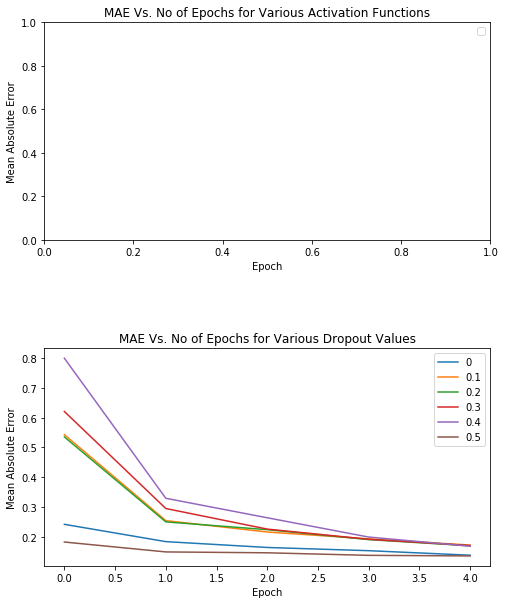

In [22]:
def plot_history(history, history2, history3, history4, history5, history6, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    #axes[0].plot(history4.history[metric])
    #axes[0].plot(history5.history[metric])
    #axes[0].plot(history6.history[metric])
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Various Activation Functions')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    axes[1].plot(history3.history['loss'])
    axes[1].plot(history4.history['loss'])
    axes[1].plot(history5.history['loss'])
    axes[1].plot(history6.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['0', '0.1', '0.2', '0.3', '0.4', '0.5'], loc='upper right')
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Various Dropout Values')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(descriptor_history_relu, descriptor_history_elu, descriptor_history_selu, descriptor_history_lin, descriptor_history_lrelu, descriptor_history_do5, 'mean_absolute_error')

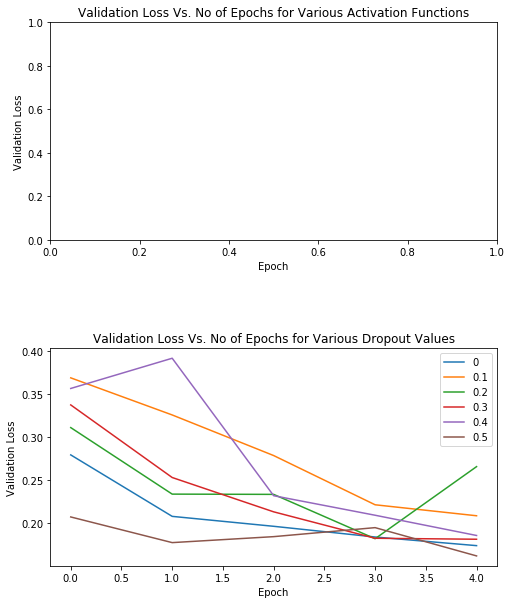

In [24]:
def plot_val_history(history, history2, history3, history4, history5, history6, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      axes[0].plot(history3.history['val_'+metric])
      axes[0].plot(history4.history['val_'+metric])
      axes[0].plot(history5.history['val_'+metric])
      #axes[0].plot(history6.history['val_'+metric])
      axes[0].legend(['ReLU', 'ELU', 'SELU', 'Linear', 'LeakyReLU'], loc='upper right')

    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for Various Activation Functions')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      axes[1].plot(history3.history['val_loss'])
      axes[1].plot(history4.history['val_loss'])
      axes[1].plot(history5.history['val_loss'])
      axes[1].plot(history6.history['val_loss'])
      axes[1].legend(['0', '0.1', '0.2', '0.3', '0.4', '0.5'], loc='upper right')

    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Various Dropout Values')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(descriptor_history_relu, descriptor_history_elu, descriptor_history_selu, descriptor_history_lin, descriptor_history_lrelu, descriptor_history_do5, 'mean_absolute_error')